# Helping Hotels in times of flexible bookings

Nearly 40 percent of on-the-books revenue is canceled before arrival, according to a study conducted by D-Edge Hospitality Solutions. The company analyzed the online distribution performance of more than 200 different channels for 680 properties in Europe between 2014 and 2018. Guests have become accustomed to free cancellation policies that have been made popular mainly by Booking.com. This customer behavior hinders accurate forecasting, eventually resulting in non-optimized occupancy.

The pandemic has changed the tourism industry and accelerated this development. 100% refund policies are meant to encourage customers to book hotels in an uncertain environment, however, this imposes cost to a hotel business, as rooms are reserved for a long time and then might be cancelled shortly in advance. This short time is often not enough to find a new, paying customer for the hotel room.

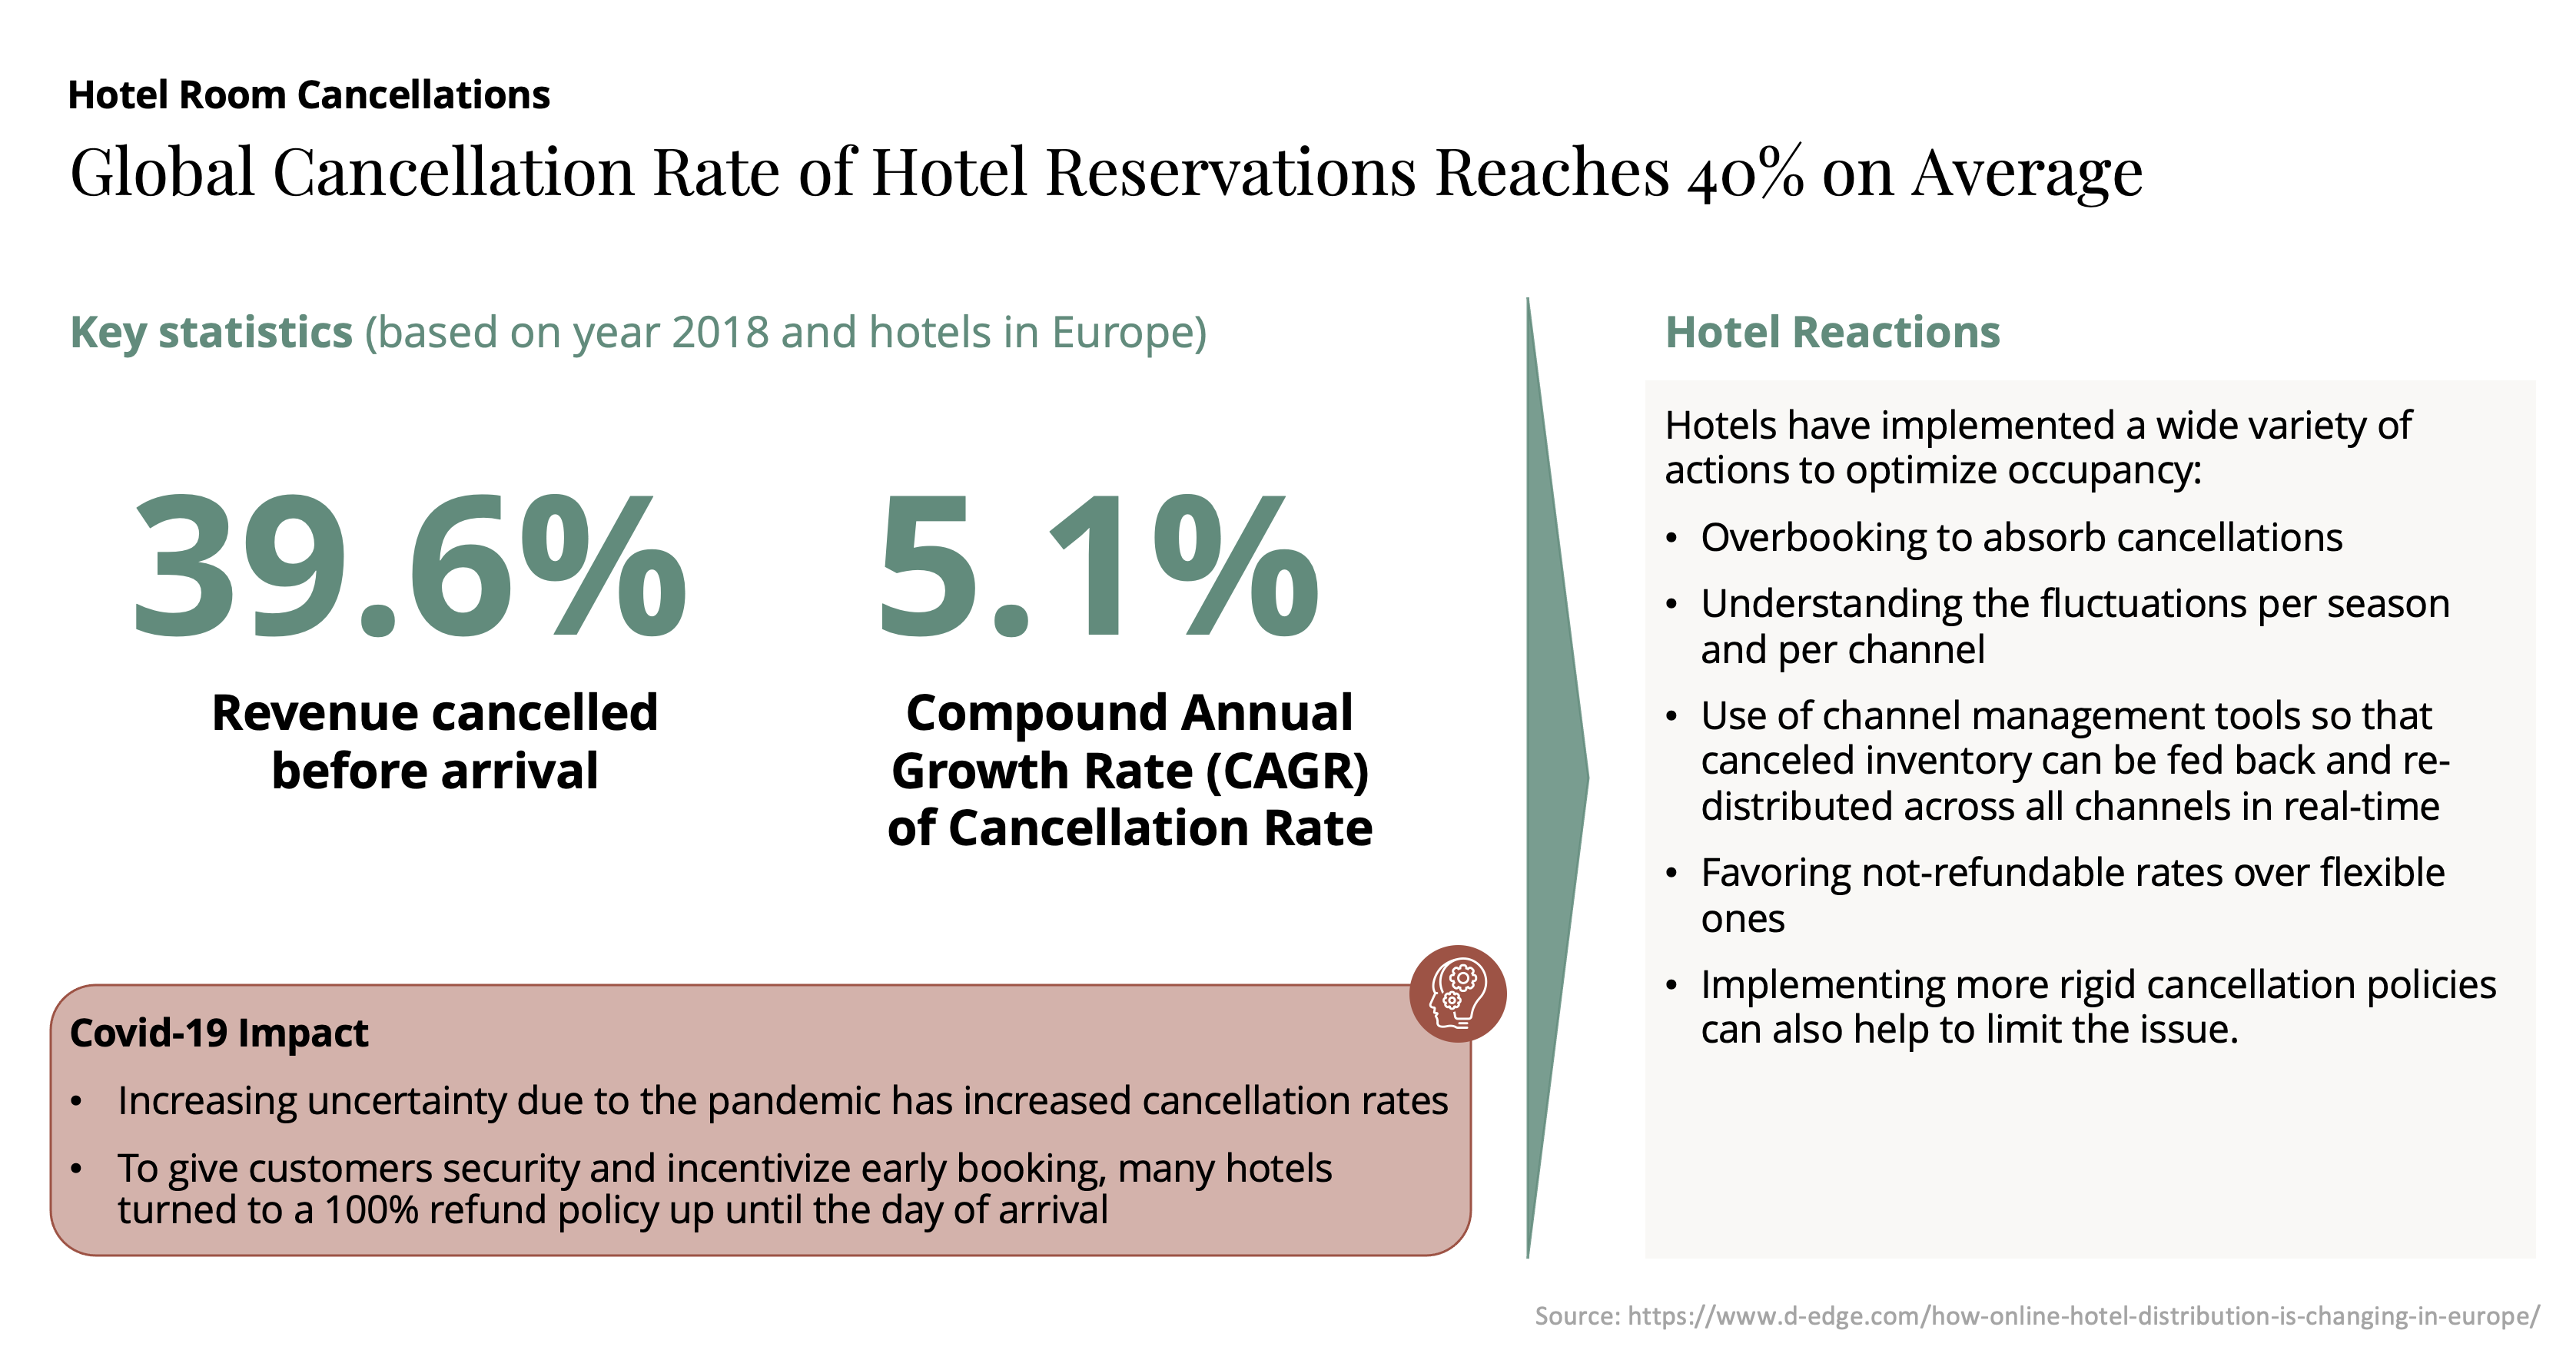

However, reducing the flexibility of bookings by dropping the user-friendly refund terms might put the hotel's competitiveness at risk. Therefore hotels might use a concept that is already prevailent in airlines: Overbooking the rooms they actually have and thereby absorbing the canellations (see abstraction below). By accepting more bookings than a hotel has rooms, it can make sure to be closer to full capacity utilization. However, this imposes the risk of not having rooms available and having to reject customers that have a reserved room. Therefore building a Machine Learning model that successfully predicts whether a customer is likely to cancel their booking is crucial in enabling the hotels to overbook the optimal number of rooms. That is the goal of this work.

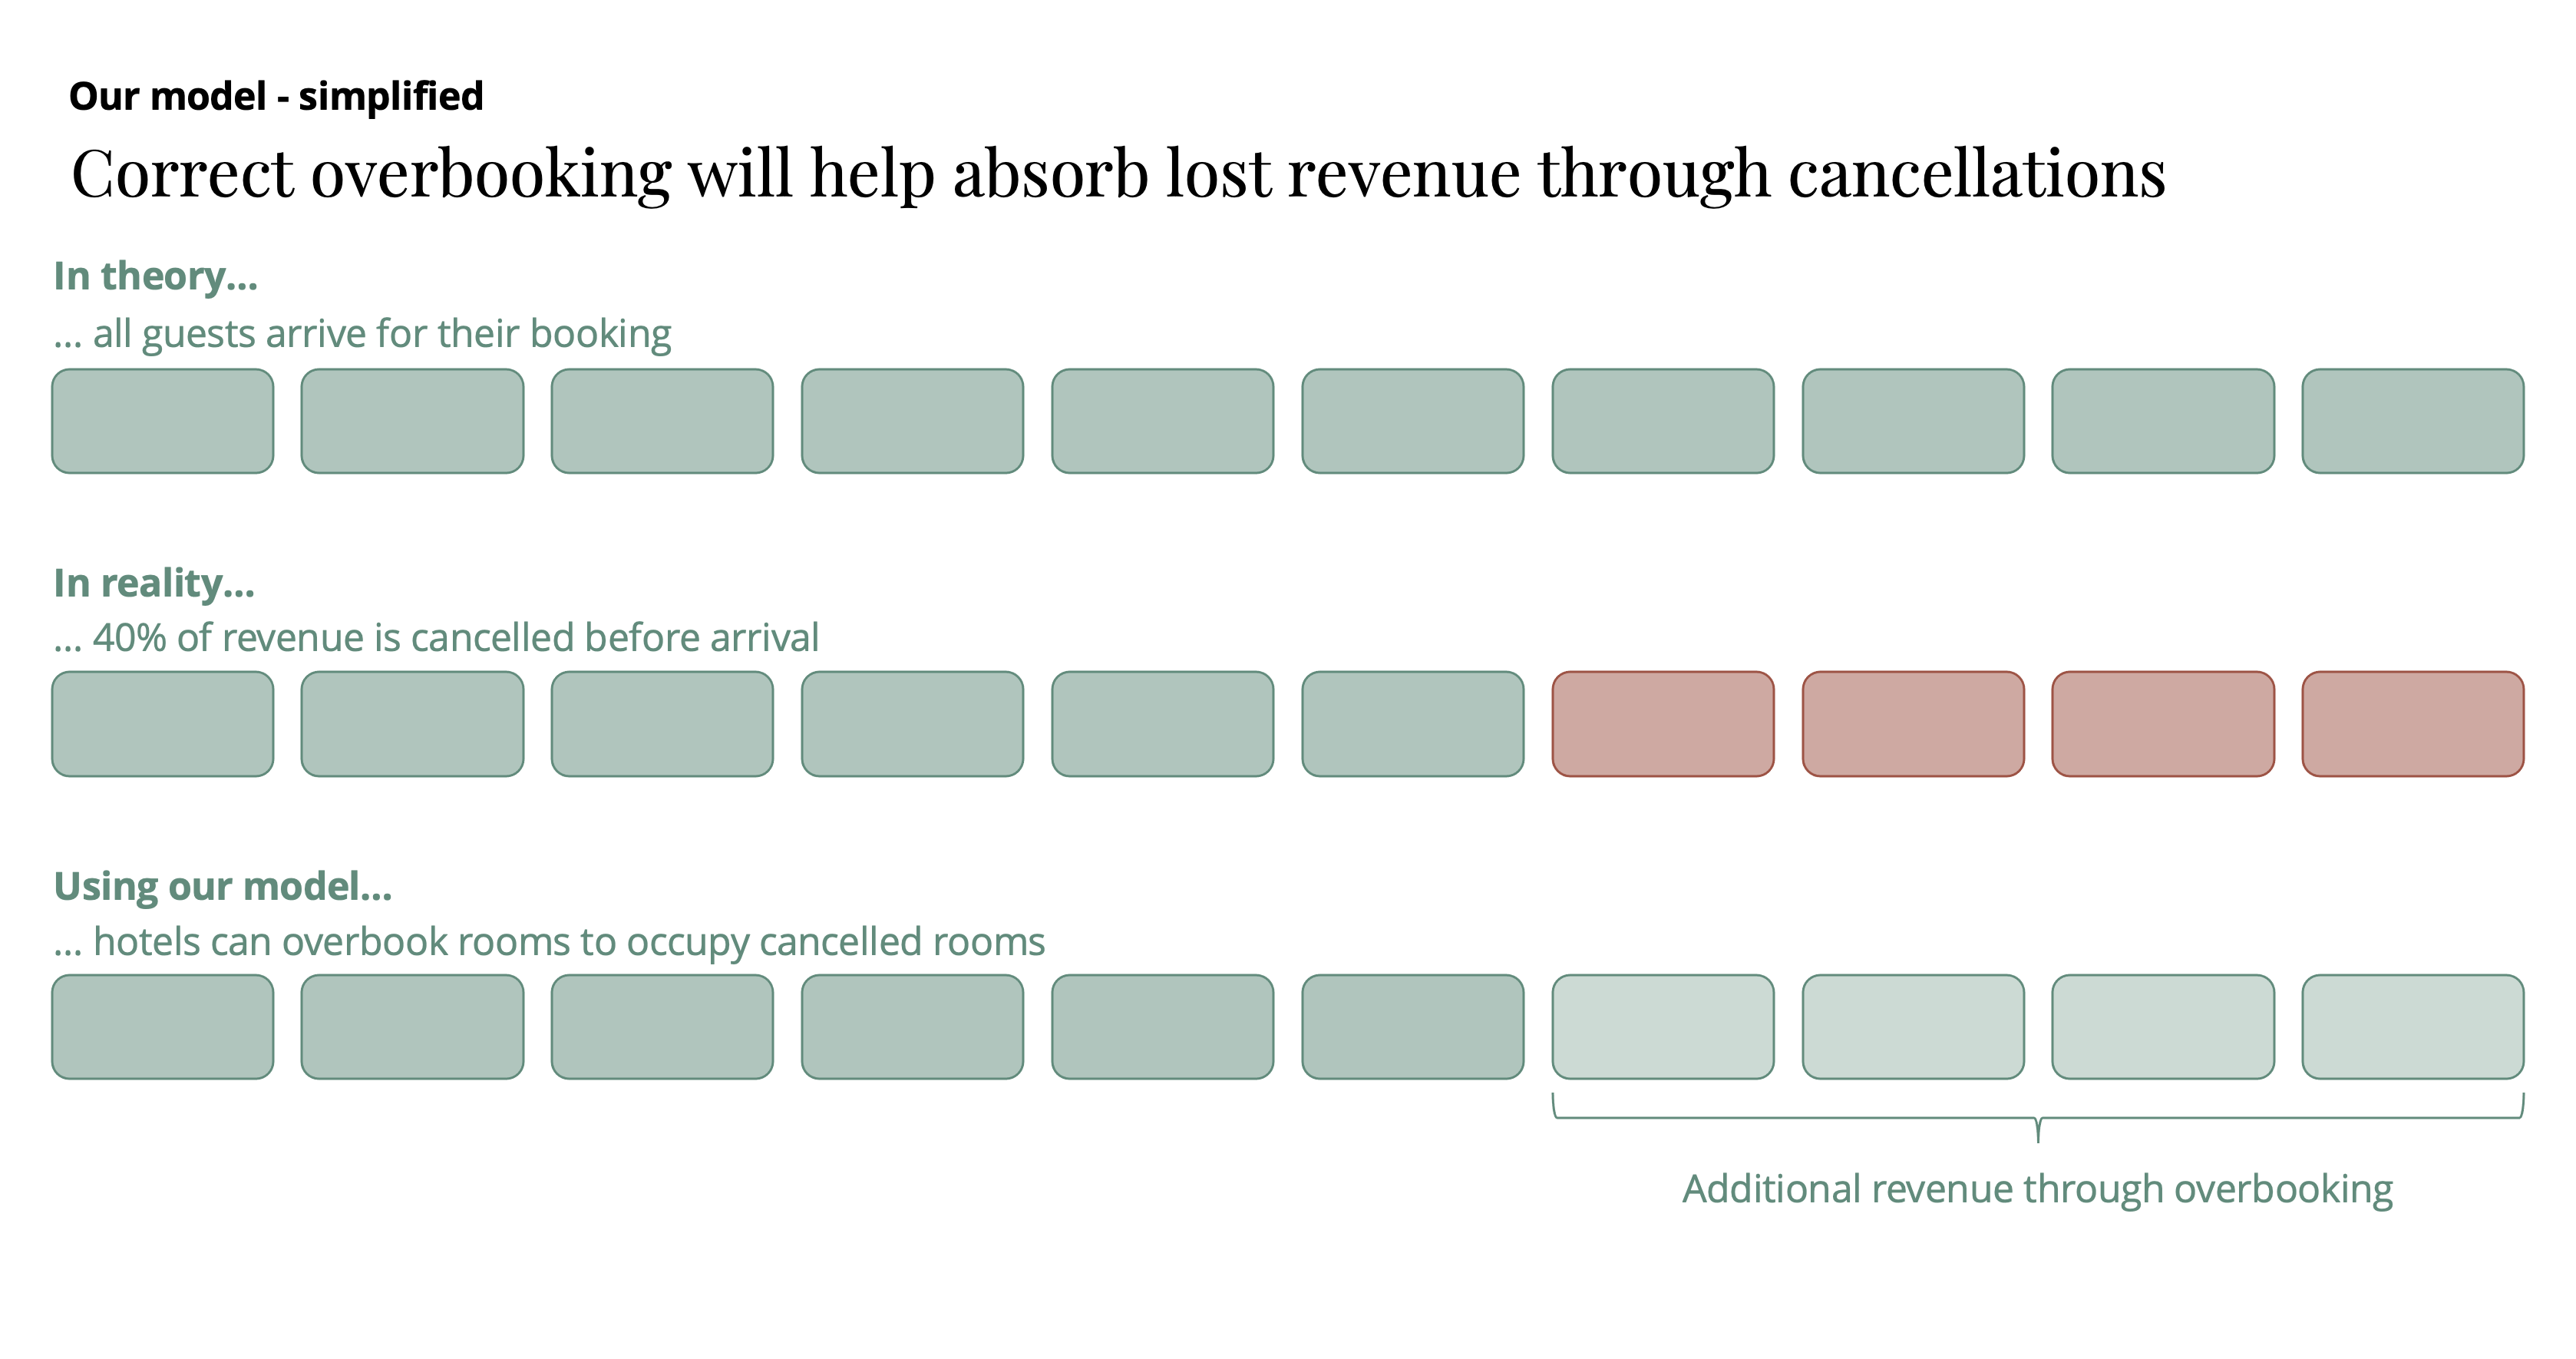

**After building our model, we successfully show that using our prediction algorithm, we can substantially improve the businesses revenue in the peak summer months. You can find the calculation [here](#businesscase).**

### Select a performance measure

In order to select an appropriate performance measure for our model, we first have to discuss the outcomes of each case:

- *Cost of False Positives:*
<br>In this case, **we predict that a customer cancels the room, but he actually doesn't cancel** and shows up
<br>The hotel runs into the risk of having too many customers show up and therfore not being able to serve all of them with rooms. This can have bad consequences and negatively impact the reputation of the hotel. Avoiding this scenario should be of high priority, however revenue is not directly effected.
<br>
<br>
- *Cost of False Negatives:*
<br>In this case, **we predict that a customer does not cancel the room, but he actually cancels** and does not show up
<br>As the model does not predict a cancellation, the hotel does not overbook this room. Therefore, this scenario may lead to unoptimized occupancy, especiallly if cancellations are short-term and the hotel is not able to react appropriately.
<br>
<br>
- *Gain of True Positives:*
<br>In this case, **we correctly predict that a customer cancels the room** and does not show up
<br>Through the use of overbooking, Hotels will be able to fill this room. The use of our model will therefore lead to additional revenue through better occupancy and not loose the money due to loose refund policies.
<br>
<br>
- *Gain of True Negatives:*
<br>In this case, **we correctly predict that a customer does not cancel the room** and shows up
<br>The customer behaves in line with expactations and will occupy the room. The use of our model neither increases nor decreases revenue.
<br>
<br>

In the case of hotel booking, false positives and false negatives balance each other out. Let's look at an example:
<br>We falsely predict that two customers cancel the room (while they actually don't), and at the same time falsely predict that three customers do not cancel the room (while they actually do). In this case, the hotel has three empty rooms, but is able to fill them with the two customers that show up even though they were predicted as canceled. Consequently, all customers can be served with a room and - while there is still unserved capacity - the hotel does not suffer a loss of reputation.

Based on the previous assessment, **we choose the F1-score as our performance measure**. The F1-score elegantly sums up the predictive performance of a model by combining two otherwise competing metrics — precision and recall. It is calculated as follows:

$$
\
F1=\frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\
$$

In our use-case, the errors caused by FPs and FNs are equally undesirable. In fact, we care about having them as equal as possible. We want Recall and Precision to be as high as possible, without focussing more on one of the measures. Therefore, we choose F1 as the appropriate measure of performance.

This performance measure is also dependent on which type of hotel is using the model. As we don't have an indication for the hotel in our case, we assume it is a mid-range establishment - neither budget, nor luxurious. However, for luxurious hotels, reputation is everything. Therefore, we woud recommend using Recall as the performance measure, because false positives, i.e. the risk of too many bookings, are more costly. In the opposite case, for budget hotels, it is more important to have better capacity than loose reputation by overbooking, we therefore recommend using Precision as performance measure in these cases.

### Check the assumptions

The result of this model is a classification of whether a room will be cancelled or not. We can use this information to precisely overbook certain rooms on a daily basis. This is based on the assumptions that this is the information that hotels need to use overbooking as a way to optimize capacity. Instead of simply forecasting cancellation rates for upcoming weeks (as it is current practice), our model predicts cancellations on a much more granular level. This makes it possible to react more fexible and on a per-room basis.

## 0. Imports & Data Access

In [1]:
import matplotlib.pyplot as plt
import missingno
import pandas as pd
import seaborn as sns
import numpy as np
import os
from datetime import timedelta
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from typing import Dict, List
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Binarizer, FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
#import tensorflow as tf
#import tensorflow.keras as keras
from typing import Union
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#from sktime.forecasting.model_selection import ForecastingGridSearchCV
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn')
seed = 42

C:\Users\erikf\Desktop\Master BA\S2\Machine Learning\Hotel-Booking-ML\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
exec_directory = os.getcwd()
main_directory = "Hotel-Booking-ML"
main_dir_path = exec_directory[:exec_directory.find(main_directory) + len(main_directory)]
raw_data_files_location = f"{main_dir_path}/data/raw"
df_all = pd.read_csv(f"{raw_data_files_location}/hotel_booking.csv")

## 1. Data Exploration

In [3]:
df_all.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


As a first step we'll drop the columns 'reservation_status' and 'reservation_status_date' as they include information on our label. The value 'canceled' in 'reservation_status' indicates the same as 'is_canceled', this obviously information we don't need and shouldn't feed into the model.

In [4]:
df_all.drop(columns = ['reservation_status', 'reservation_status_date' ], inplace = True)

<AxesSubplot:>

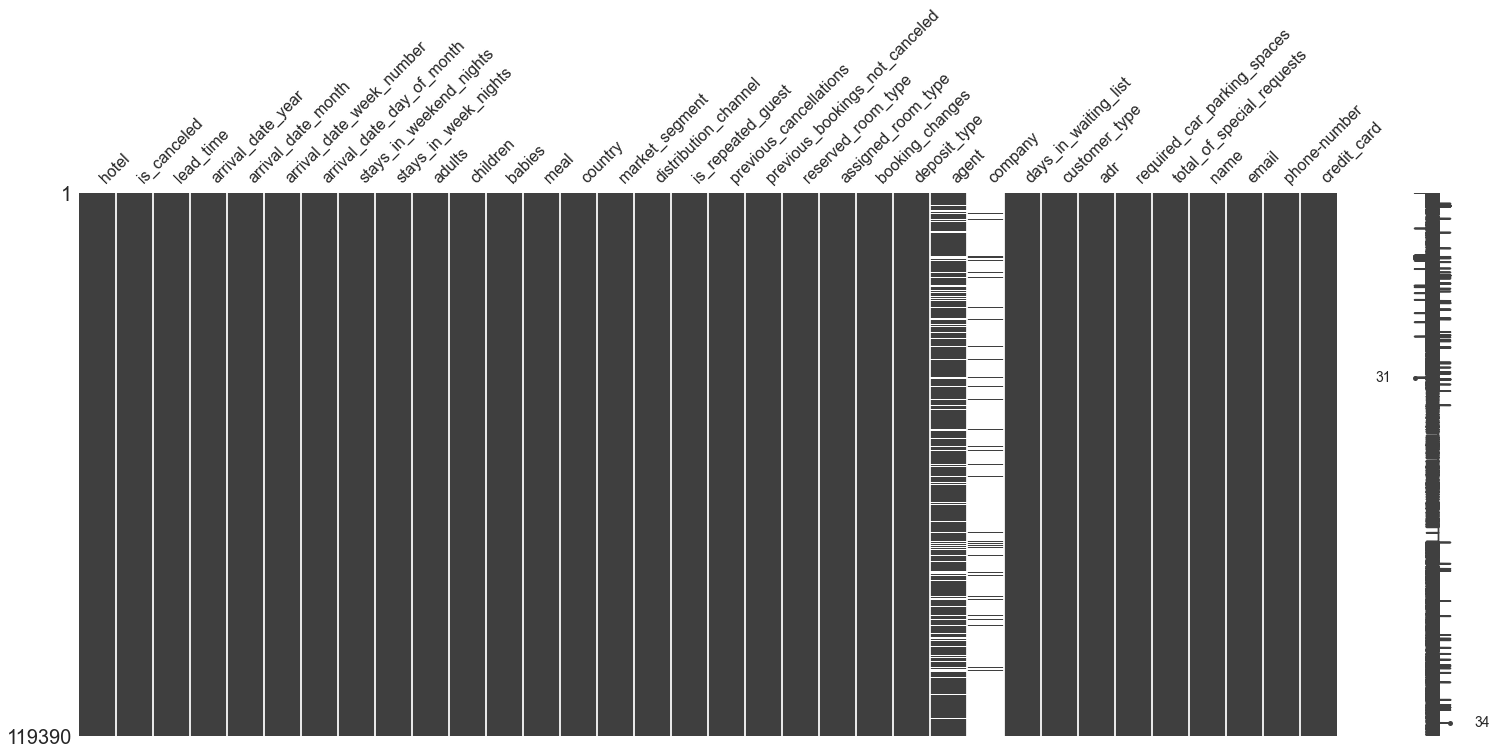

In [5]:
missingno.matrix(df_all)

#### Missing values

Luckily our dataset is mostly complete for all features apart from agent and company. According to the data dictionary of the dataset these columns represent IDs of the agents and companies (in case of business travel) that made the bookings. Therefore it is likely that missing values do represent an information: a NA in 'company' indicates that the booking was not a business travel and a NA in 'agent' indicates that no agent was used for the booking, meaning that it was a direct booking.

Therefore we'll use OneHot encoding later on, to understand if there is a correlation between company, agent and our labels. 

#### Data transformation and aggregation. 

Before starting with the EDA, we try combine attributes to generate new information or aggregate redundant information.

We'll transform arrival and booking date to datetime format and transform the type of children in order to facilitate subsequent code operations. <br> We'll also aggregate data by calculating the number of total nights and retrieving the total number of guests. The aim of this is to reduce the number of features by aggregating redundant / similar information. <br> Furthermore, we'll add a column that represents the average daily revenue per guest instead of the total ADR of all guests of a booking.

In [6]:
df_all.dropna(subset=['children'], inplace=True)
df_all['children'] = df_all['children'].astype(int)
df_all = df_all.astype({"country": str})

In [7]:
# Getting arrival and booking dates right
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
                         'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df_all['arrival_date_month'] = df_all['arrival_date_month'].apply(lambda m: month_mapping[m])
df_all['arrival_date'] = pd.to_datetime(dict(year = df_all.arrival_date_year, 
                                         month = df_all.arrival_date_month, 
                                         day = df_all.arrival_date_day_of_month))
df_all['booking_date'] = df_all.apply(lambda r: r['arrival_date'] - timedelta(days=r['lead_time']), axis=1)
df_all['booking_date_day_of_week'] = df_all['booking_date'].dt.weekday

# Number of Guests
df_all['guests'] = df_all['adults'] + df_all['children'] + df_all['babies']

# Length of stay
df_all['stay_total_nights'] = df_all['stays_in_weekend_nights'] + df_all['stays_in_week_nights']

# Is Family
df_all['is_family'] = np.where((df_all['children'] >= 1) | (df_all['babies'] >= 1), 1, 0)

# Assigned room type changed from booked room type
df_all['room_changed'] = np.where(df_all['reserved_room_type'] == df_all['assigned_room_type'], 0, 1)

# Average daily revenue per guest

df_all['adr_per_guest'] = df_all['adr'] / df_all['guests'].replace({0: df_all['guests'].median()})

As a second step, we split the data in a train and a test set before working on the data, because we don't want to influence our training and analysis by any information from the test set. We are using a 22 month period from 1st of July 2015 till 1st of May 2017 for training. Later, we will test our model's performance on a 4 month period from May to August 2017. This period is also a high demand period for hotels in which well-executed overbooking can be especially benefitial.

In [8]:
import datetime
split_date = datetime.datetime(2017, 5, 1)
df = df_all[df_all['arrival_date'] < split_date]
df_test = df_all[df_all['arrival_date'] >= split_date]
print(df.shape)
print(df_test.shape)
print(f"Train: {round(df.shape[0] / df_all.shape[0] * 100, 1)}% | Test: {round(df_test.shape[0] / df_all.shape[0] * 100, 1)}%")

(97188, 42)
(22198, 42)
Train: 81.4% | Test: 18.6%


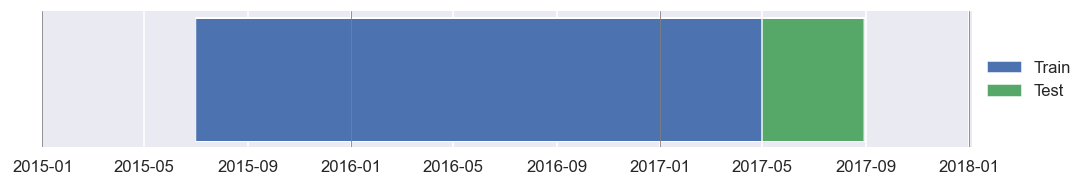

In [9]:
plt.figure(figsize=(10,1.5), dpi=120)
plt.fill_between(df.arrival_date, np.ones(df.shape[0]), label="Train")
plt.fill_between(df_test.arrival_date, np.ones(df_test.shape[0]), label="Test")
plt.xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2018, 1, 1))
for ny in ['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01']:
    plt.axvline(pd.to_datetime(ny), lw=0.5, color='grey')
plt.gca().get_yaxis().set_visible(False)
plt.xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2018, 1, 5))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## 2. Exploratory Data Analysis
We firstly split the EDA for categorical and numerical features, as we'll perform different analysis methods for each data type.

There are two exceptions here:
- We'll see binary variables (with 0 and 1) as a numerical feature, as it can be analyzed with the methods we use for the 'true' numerical features.
- The 'hotel' feature describes whether the data is for a 'City Hotel' or a 'Resort Hotel', it will be analyzed in numerical features as well. This is because we want to identify if it is worth to split the data we have according to the hotel and build separate models for each of the hotels.

In [10]:
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,phone-number,credit_card,arrival_date,booking_date,booking_date_day_of_week,guests,stay_total_nights,is_family,room_changed,adr_per_guest
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,...,669-792-1661,************4322,2015-07-01,2014-07-24,3,2,0,0,0,0.0
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,...,858-637-6955,************9157,2015-07-01,2013-06-24,0,2,0,0,0,0.0
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,...,652-885-2745,************3734,2015-07-01,2015-06-24,2,1,1,0,1,75.0
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,...,364-656-8427,************5677,2015-07-01,2015-06-18,3,1,1,0,0,75.0
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,713-226-5883,************5498,2015-07-01,2015-06-17,2,2,2,0,0,49.0


In [11]:
categorical_features = [ 'meal', 'country', 'market_segment', 'distribution_channel', 
                         'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 
                         'customer_type']

df_num = df.drop(columns = categorical_features)

categorical_features.append('is_canceled')
df_cat = df[categorical_features]

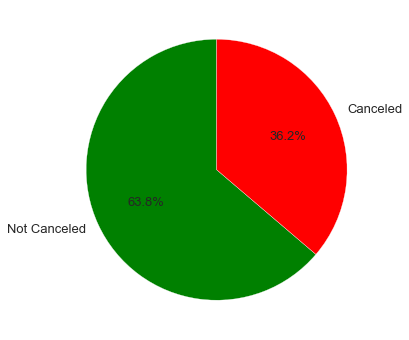

In [12]:
#display canceled and not canceled 
num_can = df['is_canceled'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(num_can, labels=['Not Canceled', 'Canceled'], 
        autopct='%.1f%%', 
        startangle=90, 
        colors = ['green', 'red'],
        textprops={'fontsize': 13})
plt.show()

The share of cancellations (36.2%) is quite similar to the average share of canceled revenue for Europe in 2018 (39.6%), as found in the study mentioned in 1.

### 2.1 Numerical features
#### 2.1.1 Correlations

First we'll take a look at collinearity in the data set, by pairplotting relevant features and calculating their correlations.

Please note that we are only using aggregated features here and not the features we calculated these aggregated ones on. For example, it wouldn't make sense to check for collinearity in guests with adults, children or babies as these variables are obviously correlated and won't be used side by side in the model. 

<AxesSubplot:>

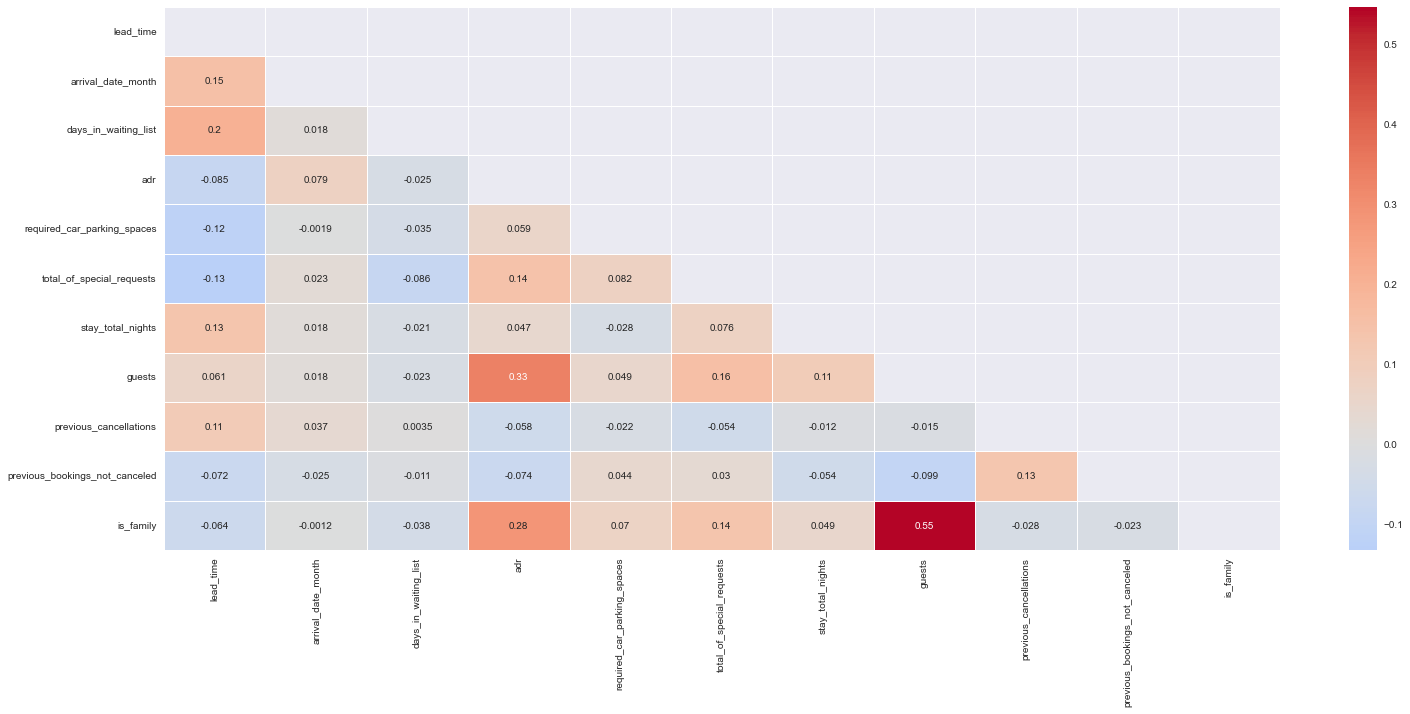

In [16]:
plt.figure(figsize=(25,10))
corr = df_num[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr','required_car_parking_spaces', 'total_of_special_requests',
               'stay_total_nights', 'guests','previous_cancellations','previous_bookings_not_canceled','is_family']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

#Plot Correlation Heatmap
sns.heatmap(corr,
            annot = True,
            linecolor = 'white',
            mask = mask,
            linewidths = 1,
            center = 0,
            cmap = 'coolwarm') 

In [17]:
df_corr = pd.DataFrame(df_num[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr', 
                          'required_car_parking_spaces', 'total_of_special_requests',
                          'stay_total_nights', 'guests','previous_cancellations','previous_bookings_not_canceled','is_family']].corr().unstack()).rename({0: 'correlation'}, axis=1)
df_corr[df_corr['correlation'] != 1].sort_values(by='correlation')

,,correlation
lead_time,total_of_special_requests,-0.132239
total_of_special_requests,lead_time,-0.132239
lead_time,required_car_parking_spaces,-0.118180
required_car_parking_spaces,lead_time,-0.118180
previous_bookings_not_canceled,guests,-0.098961
...,...,...
is_family,adr,0.281356
adr,guests,0.332327
guests,adr,0.332327
is_family,guests,0.546240


The highest correlation among our features is the correlation of ADR (revenue per day) with the number of guests, this follows the logic that with the more people you stay in a hotel, the more you'll spend. When building the model we'll take a closer look if this becomes a problem. For the other features the correlations are really small and therefore no worry.  

Now, lets get the correlations of the **label** with the features, separately for the resort and city hotel to find out if they differ substiantially. This will be interesting when deciding whether to build separate models or not. 

In [18]:
correlations_all = df_num.corr()['is_canceled'].sort_values(ascending=False)
correlations_city = df_num[df_num['hotel'] == 'City Hotel'].corr()['is_canceled']
correlations_resort = df_num[df_num['hotel'] == 'Resort Hotel'].corr()['is_canceled']
correlations_df = correlations_all.to_frame().rename({'is_canceled': "All"}, axis=1)
correlations_df = correlations_df.join(correlations_city).rename({'is_canceled': "City"}, axis=1)
correlations_df = correlations_df.join(correlations_resort).rename({'is_canceled': "Resort"}, axis=1)
correlations_df

,All,City,Resort
is_canceled,1.000000,1.000000,1.000000
lead_time,0.322420,0.350271,0.223346
previous_cancellations,0.126483,0.197640,0.131513
adults,0.062478,0.056767,0.081217
days_in_waiting_list,0.061571,0.067168,-0.037844
guests,0.046230,0.027032,0.091215
booking_date_day_of_week,0.041744,0.036477,0.035346
adr,0.035537,-0.023667,0.073375
stays_in_week_nights,0.018612,0.045250,0.068652
arrival_date_month,0.017985,0.013205,0.025082


This already gives a good indication, but let's plot the data to make the difference easier to understand.

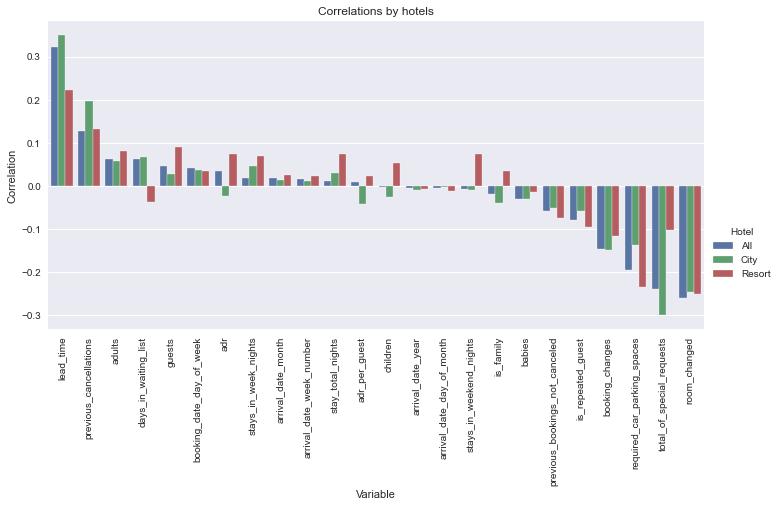

In [19]:
correlations_plot_df = pd.melt(correlations_df.drop('is_canceled'), ignore_index=False, var_name="Hotel", value_name="Correlation")
correlations_plot_df['Variable'] = correlations_plot_df.index
sns.catplot(data=correlations_plot_df, kind='bar', x='Variable', y='Correlation', hue='Hotel', aspect=2)
plt.xticks(rotation=90)
plt.title('Correlations by hotels')
plt.show()

This bar-chart shows that lead_time, previous_canellations, total_of_special_requests, required_car_parking_space and booking_changes have a correlation that is higher than 0.1 (in absolute terms). These are important candidates for our ML model later on. Additionally, the chart shows that for some features the correlation heavily depends on the kind of hotel we are looking at: For example, the number of total special requests is highly correlated with the cancellations at the city hotel, but not so much at the resort hotel.

We can see that the lead time is highly correlated with the label. It's interesting to see patterns for the length of the lead time and the related cancellations, for each hotel.

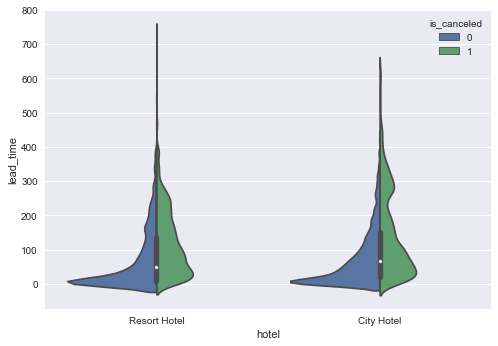

In [20]:
sns.violinplot(data=df, x='hotel', y='lead_time', hue='is_canceled', split=True)
plt.show()

For the city hotel, the vast majority of bookings with lead time > 200 days gets canceled, while for the resort hotel this tendency also exists, but is not equally strong. We can also see that most bookings are made only days before arrival. These are then less likely to be cancelled.

The column *'booking_changes'* describes changes that cumulate over time. This count can change until the day of arrival. For our model, this will not be usable since when making a prediction if a customer cancels, we don't know how many changes they will make to the booking in the future. Thus, *'booking_changes'* will be disregarded for the model.

Some continuous numeric variables can also be transformed into binary form by simply checking whether they are > 0, which could benefit the model's performance. In order to find out which option should be picked, we will look at the correlations with the target variable is_canceled. Let's first look at *total_of_special_requests* vs. *any_requests*.

In [25]:
df_corrcheck = df
df_corrcheck['any_requests'] = df_corrcheck.total_of_special_requests.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_requests', 'total_of_special_requests']].corr()

,is_canceled,any_requests,total_of_special_requests
is_canceled,1.000000,-0.274610,-0.238382
any_requests,-0.274610,1.000000,0.870224
total_of_special_requests,-0.238382,0.870224,1.000000


As the binary variable any_requests is more correlated with is_canceled, we will choose this option later on. Now let's inspect previous_canellations.

In [26]:
df_corrcheck['any_cancelations'] = df_corrcheck.previous_cancellations.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_cancelations', 'previous_cancellations']].corr()

,is_canceled,any_cancelations,previous_cancellations
is_canceled,1.000000,0.313100,0.126483
any_cancelations,0.313100,1.000000,0.424056
previous_cancellations,0.126483,0.424056,1.000000


This correlation is significantly higher in binary form. We will therefore use it in our model. Next up: required_car_parking_spaces.

In [27]:
df_corrcheck['any_parking'] = df_corrcheck.required_car_parking_spaces.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_parking', 'required_car_parking_spaces']].corr()

,is_canceled,any_parking,required_car_parking_spaces
is_canceled,1.000000,-0.197992,-0.195897
any_parking,-0.197992,1.000000,0.989420
required_car_parking_spaces,-0.195897,0.989420,1.000000


There is only little difference between the binary and the numeric column. We will go for the binary variable to keep the model simpler.

#### 2.1.2 Frequency Distributions

Frequency distribution of time related Data


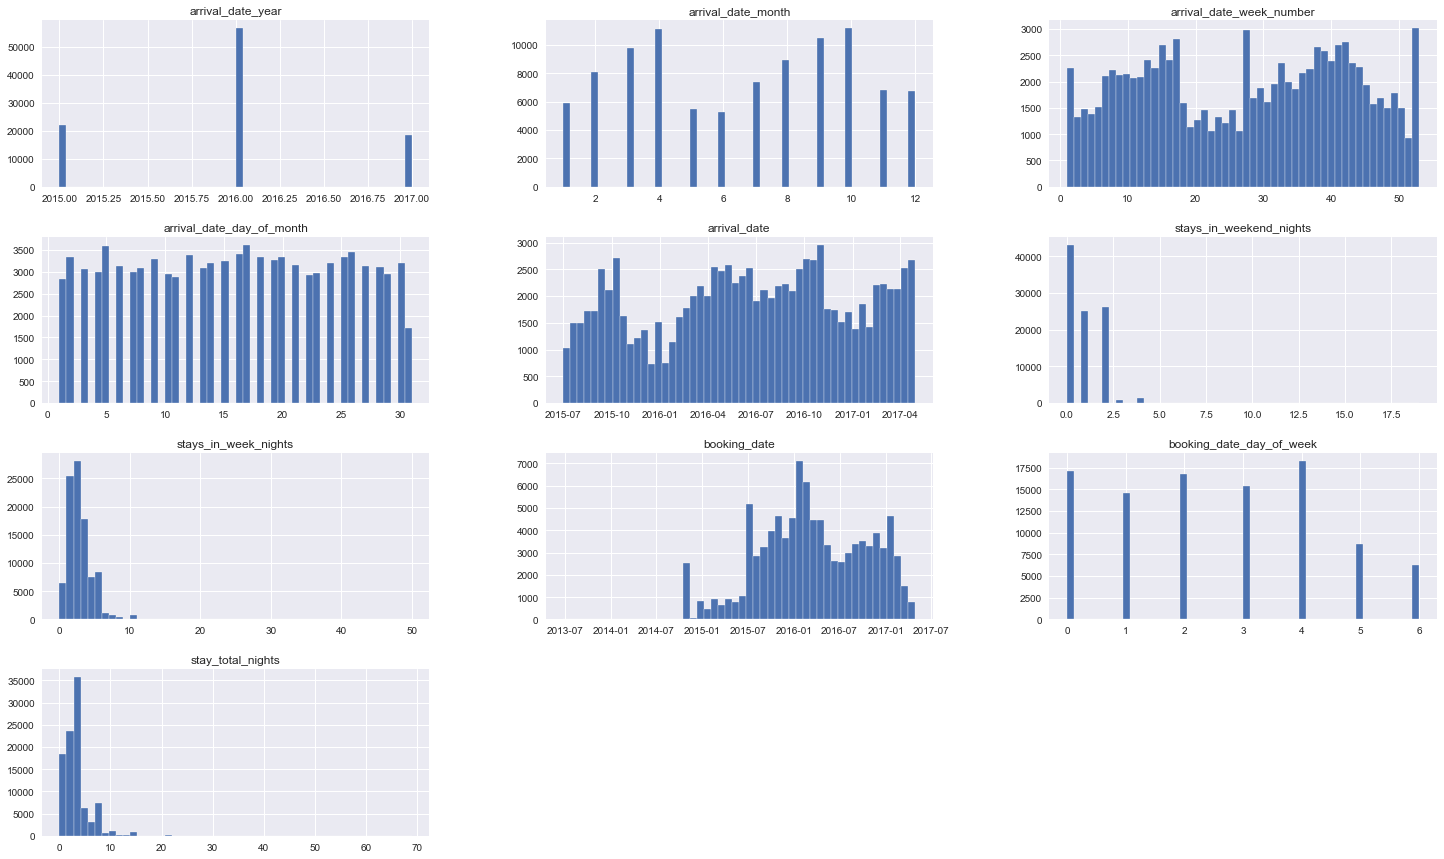

In [28]:
#time related frequency distribution 

df_num_time = df_num[['arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month' ,'arrival_date', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'booking_date',
       'booking_date_day_of_week','stay_total_nights']]

df_num_time.hist(bins=50, figsize=(25,15))
print('Frequency distribution of time related Data')
plt.show()

Frequency distribution of guest characteristics


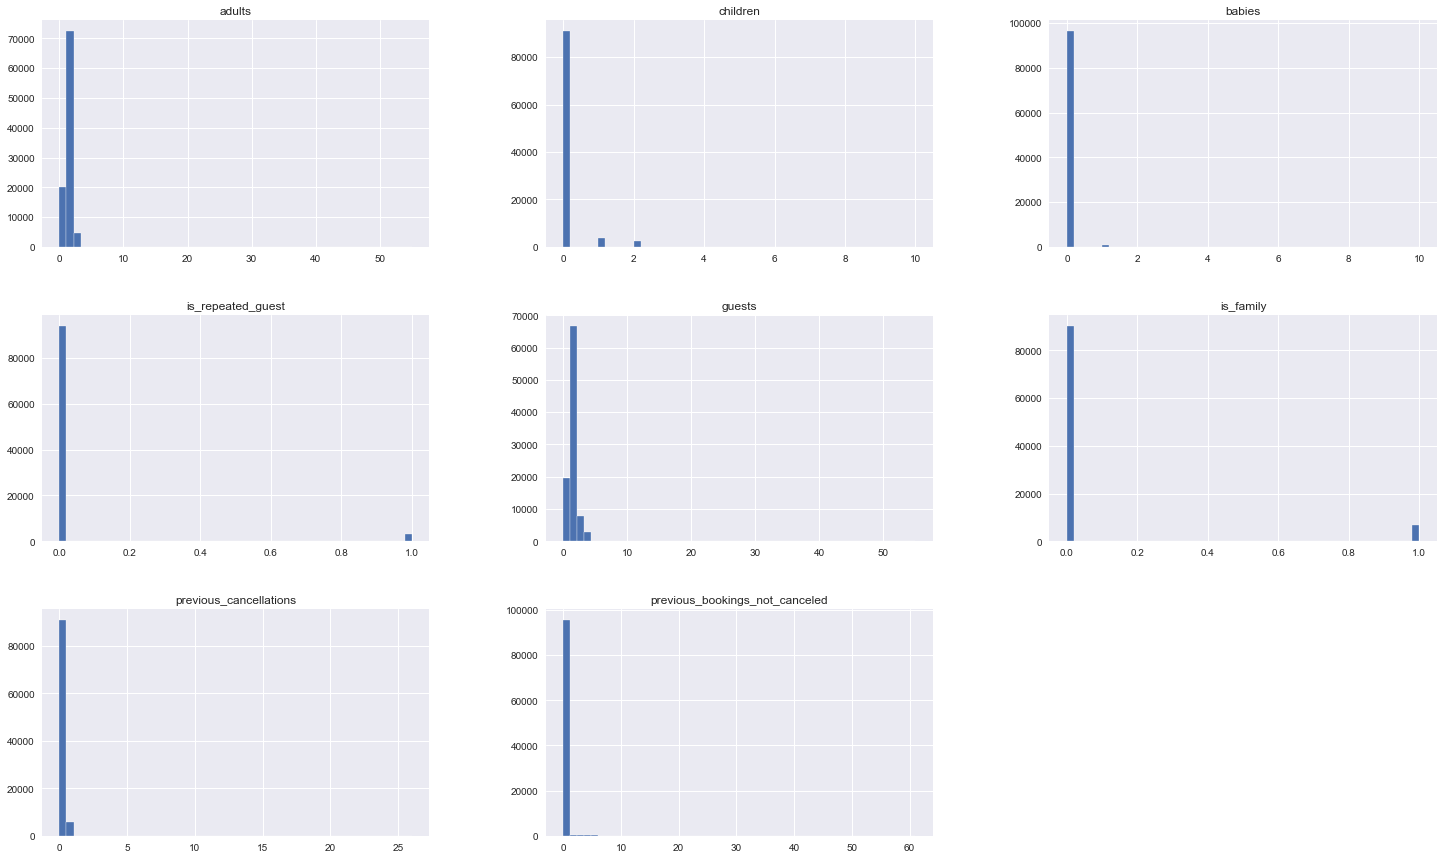

In [29]:
#guest characteristics frequency distribution

df_num_guest_characteristics = df_num[['adults', 'children', 'babies',
       'is_repeated_guest','guests', 'is_family', 'previous_cancellations',
       'previous_bookings_not_canceled']]

df_num_guest_characteristics.hist(bins=50, figsize=(25,15))
print('Frequency distribution of guest characteristics')
plt.show()

Frequency distribution of booking characteristics


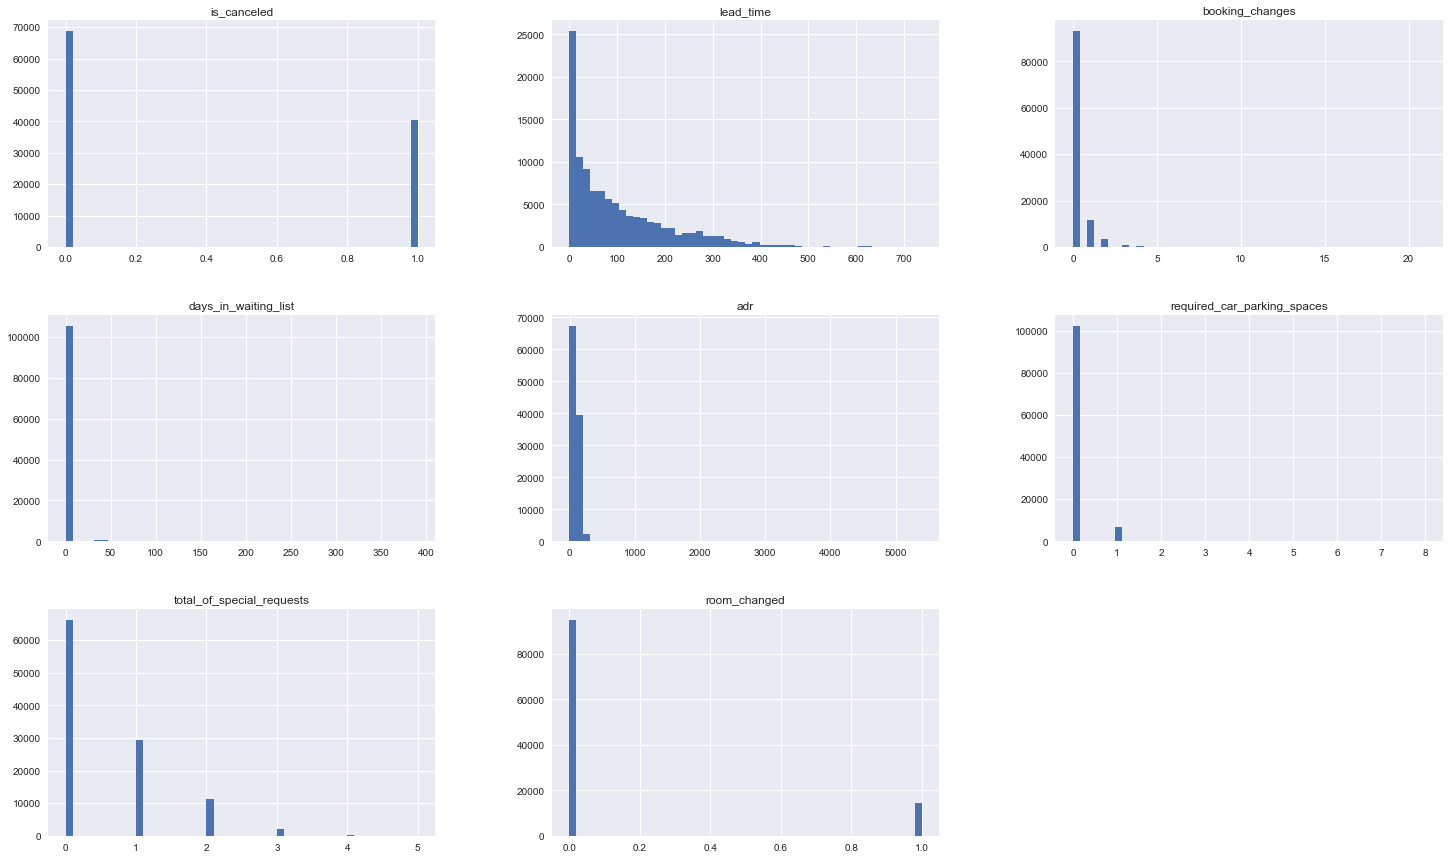

In [55]:
#booking characteristics frequency distribution

df_num_booking_characteristics = df_num[['hotel', 'is_canceled', 'lead_time', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests','room_changed']]

df_num_booking_characteristics.hist(bins=50, figsize=(25,15))
print('Frequency distribution of booking characteristics')
plt.show()

Now, we look at the characteristics of when customers usually order:

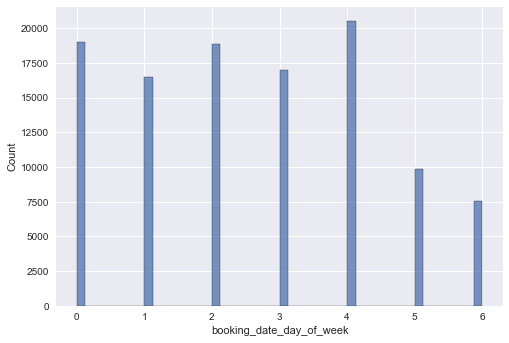

In [21]:
sns.histplot(df['booking_date_day_of_week'])
plt.show(sns)

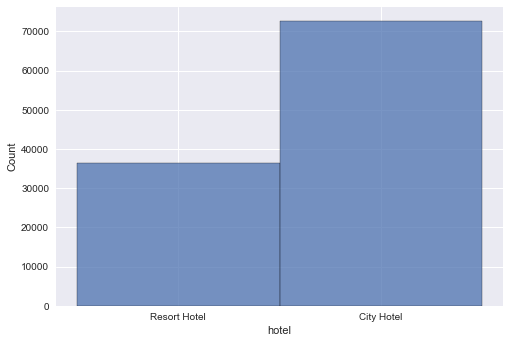

In [32]:
sns.histplot(df['hotel'])
plt.show(sns)

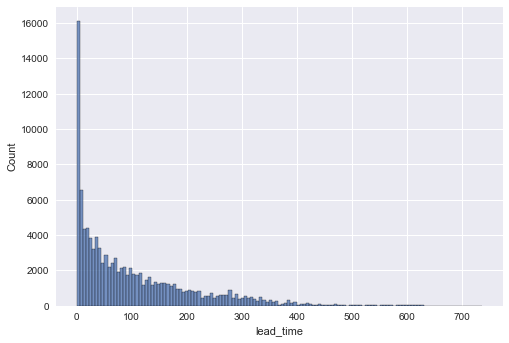

In [23]:
sns.histplot(df['lead_time'])
plt.show(sns)

### 2.2 Categorical variables

#### 2.2.1 Understanding the categories

Here we'll use df_cat, with all categorical features we have identified perviously. 

In [24]:
df_cat.columns

Index(['meal', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'company', 'customer_type', 'is_canceled'],
      dtype='object')

'Company' and 'agent' are columns with ids. Let's look at the values in the other ("true") categorical variables to get a feeling for what they are. 

In [25]:
df_cat[['meal']].value_counts(normalize = True)

meal     
BB           0.781718
HB           0.116548
SC           0.084546
Undefined    0.010380
FB           0.006807
dtype: float64

In [26]:
df_cat[['country']].value_counts(normalize = True).head(10)

country
PRT        0.421648
GBR        0.099076
FRA        0.087230
ESP        0.069905
DEU        0.058627
ITA        0.031279
IRL        0.028072
BEL        0.018342
BRA        0.018333
NLD        0.017517
dtype: float64

In [27]:
df_cat[['market_segment']].value_counts(normalize = True)

market_segment
Online TA         0.455712
Offline TA/TO     0.208304
Groups            0.177685
Direct            0.102888
Corporate         0.046762
Complementary     0.006523
Aviation          0.002126
dtype: float64

In [28]:
df_cat[['distribution_channel']].value_counts(normalize = True)

distribution_channel
TA/TO                   0.817505
Direct                  0.121395
Corporate               0.059360
GDS                     0.001732
Undefined               0.000009
dtype: float64

In [29]:
df_cat[['reserved_room_type']].value_counts(normalize = True)

reserved_room_type
A                     0.732519
D                     0.154341
E                     0.052598
F                     0.023308
G                     0.016519
B                     0.009547
C                     0.006349
H                     0.004673
P                     0.000092
L                     0.000055
dtype: float64

In [30]:
df_cat[['assigned_room_type']].value_counts(normalize = True)

assigned_room_type
A                     0.625710
D                     0.209807
E                     0.064069
F                     0.030784
G                     0.020486
C                     0.019038
B                     0.019002
H                     0.005644
I                     0.003033
K                     0.002327
P                     0.000092
L                     0.000009
dtype: float64

In [31]:
df_cat[['deposit_type']].value_counts(normalize = True)

deposit_type
No Deposit      0.867116
Non Refund      0.131510
Refundable      0.001374
dtype: float64

In [30]:
df_cat[['customer_type']].value_counts(normalize = True)

customer_type  
Transient          0.728506
Transient-Party    0.229884
Contract           0.036826
Group              0.004785
dtype: float64

Especially, the deposit type seems likely to have a high explanatory power. If you have made no deposit you are much more likely to cancel a booking than when you made a non-refundable deposit, right?

#### 2.2.2 Correlations of categorical variables with cancellations

Let's OneHot Encode the categories and IDs (for agent and company) in the next step and get their correlations with the cancellations. 

In [31]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse = False)
df_cat = df_cat.sort_index().reset_index(drop = True)
df_cat_trans = pd.DataFrame(data = onehot.fit_transform(df_cat.drop(columns = 'is_canceled')),
                                columns = onehot.get_feature_names_out())

In [32]:
df_cat_trans = pd.concat([df_cat.is_canceled, df_cat_trans], axis = 1 )

Now we'll use this transformed dataframe of our categorical variables and find out how correlated they are with 'is_canceled'.

Watch out, the next cell takes quite a while to compute. 

In [33]:
df_cat_corr = df_cat_trans.corr()
df_cat_corr = df_cat_corr['is_canceled']

In [34]:
df_cat_corr.sort_values()

deposit_type_No Deposit       -0.500463
market_segment_Direct         -0.154167
distribution_channel_Direct   -0.151399
assigned_room_type_D          -0.141988
country_FRA                   -0.128978
                                 ...   
assigned_room_type_A           0.222777
market_segment_Groups          0.233520
country_PRT                    0.354154
deposit_type_Non Refund        0.505148
is_canceled                    1.000000
Name: is_canceled, Length: 864, dtype: float64

This is gives a dataframe of 864 correlations with the label. Very likely, most of them will have a very low correlation with the label. Therefore, let's only look at the ones with a correlation of more than 0.05 (positive or negative).

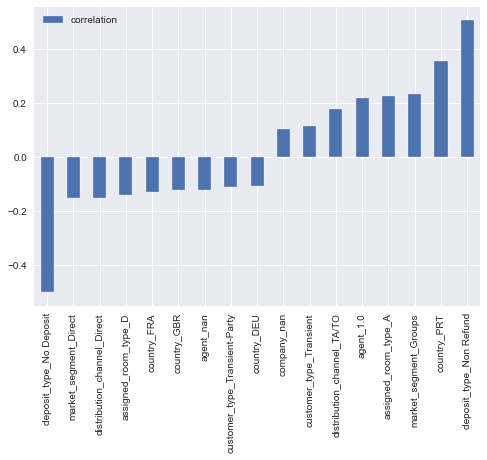

In [35]:
df_cat_corr_red = pd.DataFrame(df_cat_corr).rename({'is_canceled' : 'correlation'}, axis = 1)
df_cat_corr_red = df_cat_corr_red[(df_cat_corr_red['correlation'] >= 0.1 ) | (df_cat_corr_red['correlation'] <= -0.1) ]
df_cat_corr_red.sort_values(by = 'correlation')[:-1].plot(kind = 'bar')
plt.show()

This gives us a good indication, that especially x2 (= 'deposit_type') is likely to have a high explanatory power. But also x1 = ('Country') equalling to Portugal, x2 (= 'market_segment') equalling to Groups can be important when building the model.

But wait... the correlation indicates that customers are more likely to cancel a booking when they get no refund and less likely to cancel when they made no deposit (they don't need to pay anything in case they cancel). Logically, this should be the other way around. It seems to us, like this is a data introduction error. In order to be on the safe side, **we will exclude the attribute *deposit_type* from the model** - unfortunately, because they seem to have high explanatory value.

### 2.3 Time Series Analysis
In this section we are looking for underlying seasonality in the given cancellations and bookings.

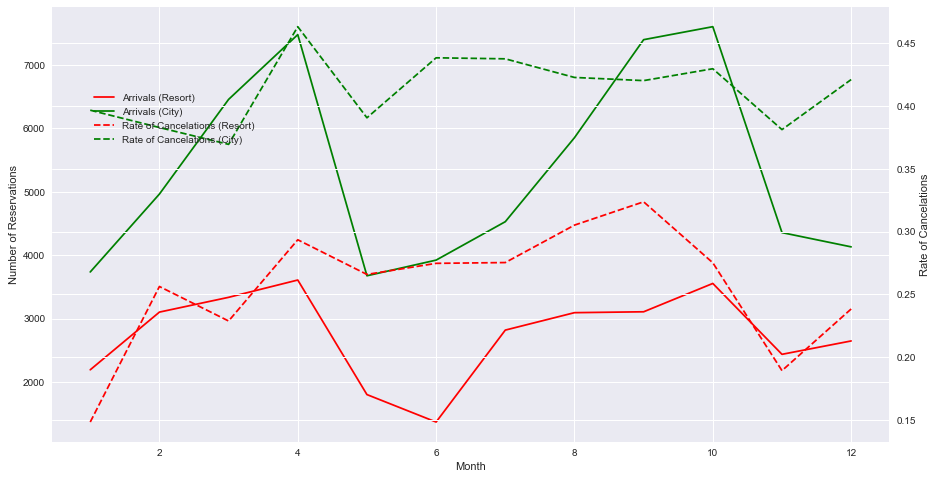

In [36]:
df_resort = df[df["hotel"] == "Resort Hotel"]
df_city = df[df["hotel"] == "City Hotel"]

#Get data for Resort Hotel
df_timeseries_r = pd.DataFrame(df_resort.groupby("arrival_date_month").size())
df_timeseries_r["Cancelations"] = df_resort.groupby("arrival_date_month")["is_canceled"].sum()
df_timeseries_r.columns = ['Arrivals', 'Cancelations']
df_timeseries_r["Cancelation_Share"] = df_timeseries_r["Cancelations"]/df_timeseries_r["Arrivals"]

#Get data for City Hotel
df_timeseries_c = pd.DataFrame(df_city.groupby("arrival_date_month").size())
df_timeseries_c["Cancelations"] = df_city.groupby("arrival_date_month")["is_canceled"].sum()
df_timeseries_c.columns = ['Arrivals', 'Cancelations']
df_timeseries_c["Cancelation_Share"] = df_timeseries_c["Cancelations"]/df_timeseries_c["Arrivals"]

#Plot linechart
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Reservations")
ax1.plot(
    df_timeseries_r["Arrivals"],
    color="red",
    label="Arrivals (Resort)"
)

ax1.plot(
    df_timeseries_c["Arrivals"],
    color="green",
    label="Arrivals (City)"
)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel("Rate of Cancelations")
ax2.plot(
    df_timeseries_r["Cancelation_Share"],
    color="red",
    linestyle="dashed",
    label="Rate of Cancelations (Resort)",
)

ax2.plot(
    df_timeseries_c["Cancelation_Share"],
    color="green",
    linestyle="dashed",
    label="Rate of Cancelations (City)",
)

fig.legend(loc = 2, borderaxespad=9)

Based on this plot, we can draw several conclusions:

- Bookings and cancellation-rate differ greatly between Resort and City Hotels. With City Hotels experiencing more bookings but also more cancellations.
- Cancellation rate follows the same patten as the number of bookings.
- Bookings and cancellations follow a seasonal pattern.

## 3. Preliminary Model Selection
Before going deeper into feature selection, we want to understand which model is the most promising for our task. For this model, more sophisticated feature selection will be conducted. We will test 5 different models that cover the spectrum of prevalent classification models, including a simple regression model, recent machine learning models and a neural network. Namely, these models are:
1. Logistic Regression
2. Random Forest Classifier
3. XGBoost Classifier
4. Support Vector Machine
5. Artificial Neural Network

### 3.1 Feature Selection Pipeline
Before testing the models, we need to build a pipeline in which all features get transformed into a format the models can best work with. Numerical features are standard scaled. For the categorical features, dimensions with less than 5% occurrences are aggregated in a 'other' category. Subsequently, categories are one-hot-encoded. The features *booking_changes* and *deposit_type* are excluded from the feature selection due to their inadequateness depicted in *2*.

In [38]:
num_features = ['lead_time', 'adr', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_week_nights', 'stays_in_weekend_nights', 'stay_total_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'days_in_waiting_list', 'total_of_special_requests', 'room_changed', 'adr_per_guest']

cat_features = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'customer_type']

class replace_other(TransformerMixin):
    """Replaces every value that accounts for less than 5% of the count of all unique
    values in the column with 'Other'"""

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, df):
        for col in df.columns:
            counts = df[col].value_counts(normalize=True)
            irrelevant = counts[counts < 0.05].index.tolist()
            df[col] = df[col].apply(lambda v: 'Other' if v in irrelevant else v)
        return df

    def get_feature_names_out(self, col_names):
        return col_names

cat_selection_pipeline = Pipeline(steps=[
    ('replace_other', replace_other()),
    ('encoder', OneHotEncoder(sparse=False))
])

feature_selection_pipeline = ColumnTransformer(transformers=[
    ('numeric', StandardScaler(), num_features),
    ('categorical', cat_selection_pipeline, cat_features)
])

In [39]:
feature_selection_df = pd.DataFrame(data=feature_selection_pipeline.fit_transform(df), columns=feature_selection_pipeline.get_feature_names_out())
feature_selection_test_df = pd.DataFrame(data=feature_selection_pipeline.transform(df_test), columns=feature_selection_pipeline.get_feature_names_out())
feature_selection_df

,numeric__lead_time,numeric__adr,numeric__arrival_date_month,numeric__arrival_date_week_number,numeric__arrival_date_day_of_month,numeric__stays_in_week_nights,numeric__stays_in_weekend_nights,numeric__stay_total_nights,numeric__adults,numeric__children,...,categorical__reserved_room_type_D,categorical__reserved_room_type_E,categorical__reserved_room_type_Other,categorical__assigned_room_type_A,categorical__assigned_room_type_D,categorical__assigned_room_type_E,categorical__assigned_room_type_Other,categorical__customer_type_Other,categorical__customer_type_Transient,categorical__customer_type_Transient-Party
0,2.351595,-2.015825,0.121937,-0.030090,-1.693688,-1.281104,-0.907927,-1.308737,0.266936,-0.245672,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,6.138408,-2.015825,0.121937,-0.030090,-1.693688,-1.281104,-0.907927,-1.308737,0.266936,-0.245672,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.860006,-0.405557,0.121937,-0.030090,-1.693688,-0.758499,-0.907927,-0.919034,-1.402064,-0.245672,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.802485,-0.405557,0.121937,-0.030090,-1.693688,-0.758499,-0.907927,-0.919034,-1.402064,-0.245672,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.792898,0.088259,0.121937,-0.030090,-1.693688,-0.235895,-0.907927,-0.529331,0.266936,-0.245672,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97183,0.175375,0.947068,-0.764987,-0.635371,1.618516,0.809315,1.094311,1.029480,0.266936,-0.245672,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
97184,0.942325,0.033724,-0.764987,-0.702625,1.504302,1.331919,1.094311,1.419182,0.266936,-0.245672,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
97185,-0.812072,2.417136,-0.764987,-0.635371,1.618516,0.809315,1.094311,1.029480,1.935935,-0.245672,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
97186,-0.831246,-1.605958,-0.764987,-0.702625,1.161660,3.422338,1.094311,2.977993,-1.402064,-0.245672,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### 3.2 Recursive Feature Elimination
As we can see, the resulting number of features is 50. This number might be too high for some models. In order to best compare them, we'll eliminate the unimportant features so that for each model, only the top 15 are left. This number serves as educated guess on how many features could be optimal but is by no means the optimal number of features. An exception form the SVM and ANN. Here, since feature reduction is less straight forward than for the other models, we take the top 15 features that appear most times within the other models.

In [49]:
top_features: Dict[str, List[str]] = {}

estimators: Dict[str, dict] = {
    'Logistic Regression': {'model': LogisticRegression(max_iter=300),
                            'rfe_possible': True},
    'Random Forest Classifier': {'model': RandomForestClassifier(),
                                 'rfe_possible': True},
    'XGBoost Classifier': {'model': XGBClassifier(objective='binary:logistic', use_label_encoder=False),
                           'rfe_possible': True},
    'SVM': {'model': SVC(probability=True),
            'rfe_possible': False}
}  # Artificial Neural Network will be considered separately under 3.3.2

for estimator in estimators:
    if not estimators[estimator]['rfe_possible']:
        continue
    else:
        estimator_model = estimators[estimator]['model']
        selector = RFE(estimator_model, n_features_to_select=15, step=10)
        selector.fit(feature_selection_df, df['is_canceled'])
        top_features[estimator] = feature_selection_df.columns[selector.support_].tolist()

all_top_features = [e for l in [top_features[estimator] for estimator in top_features] for e in l]
top_features['Highest Frequency'] = pd.Series(all_top_features).value_counts().iloc[:15].index.tolist()

/Users/patrickgundlach/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[14:57:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:57:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:57:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:57:52] WARNING: /Users/runner/miniforge3/cond

{'Logistic Regression': ['numeric__lead_time',
  'numeric__arrival_date_week_number',
  'numeric__previous_cancellations',
  'numeric__previous_bookings_not_canceled',
  'numeric__total_of_special_requests',
  'numeric__room_changed',
  'categorical__country_DEU',
  'categorical__country_GBR',
  'categorical__country_PRT',
  'categorical__market_segment_Groups',
  'categorical__market_segment_Online TA',
  'categorical__distribution_channel_Other',
  'categorical__reserved_room_type_Other',
  'categorical__assigned_room_type_Other',
  'categorical__customer_type_Transient'],
 'Random Forest Classifier': ['numeric__lead_time',
  'numeric__adr',
  'numeric__arrival_date_month',
  'numeric__arrival_date_week_number',
  'numeric__arrival_date_day_of_month',
  'numeric__stays_in_week_nights',
  'numeric__stay_total_nights',
  'numeric__previous_cancellations',
  'numeric__total_of_special_requests',
  'numeric__room_changed',
  'categorical__country_PRT',
  'categorical__market_segment_Grou

### 3.3 Model Performances
With only the top 15 features left, we can now better compare the performances of the different models.

In order to compare model performances, we define some standard functions we can apply. These functions will be used throughout the remainder of the notebook.

#### 3.3.1 Logistic Regression, Random Forest, GXBoost & SVM

In [68]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
comparison_df = pd.DataFrame(index=metrics)
fitted_models = []  # used for roc curve plot later
X_test_sets = []  # used for roc curve plot later

for model_name in estimators:
    """
    if model == ann:
        pred_proba = ann.predict(X_test.astype('float32'))[:,1]
        model_pred = np.where(pred_proba > 0.5, 1,0)

    else:
        model_pred = model.predict(X_test)
    """
    model_features = top_features[model_name] if estimators[model_name]['rfe_possible'] else top_features['Highest Frequency']
    model = estimators[model_name]['model']
    X_train_model = feature_selection_df[model_features]
    y_train_model = df['is_canceled']
    X_test_model = feature_selection_test_df[model_features]
    y_test_model = df_test['is_canceled']

    model.fit(X_train_model, y_train_model)
    model_pred = model.predict(X_test_model)

    accuracy = round(accuracy_score(y_test_model, model_pred), 4)
    recall = round(recall_score(y_test_model, model_pred), 4)
    precision = round(precision_score(y_test_model, model_pred), 4)
    f1 = round(f1_score(y_test_model, model_pred), 4)

    model_statistics = pd.DataFrame(index=metrics, data=[accuracy, precision, recall, f1], columns=[model_name])
    comparison_df = comparison_df.join(model_statistics)

    fitted_models.append(model)
    X_test_sets.append(X_test_model)

/Users/patrickgundlach/miniforge3/envs/tensorflow/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:07:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Logistic Regression,Random Forest Classifier,XGBoost Classifier,SVM
Accuracy,0.7534,0.7464,0.7611,0.7603
Precision,0.7376,0.7547,0.7417,0.7518
Recall,0.6083,0.5550,0.6306,0.6105
F1 Score,0.6667,0.6397,0.6816,0.6738


#### 3.3.2 Artificial Neural Network
In addition to "normal" machine learning models, we also want to try an Artificial Neural Network. Since the process of training and predicting is different, in the following we will compute relevant metrics and append them to the previously computed.

In [20]:
# Building the ANN
model = keras.Sequential()
model.add(keras.Input(shape=(15,)))
model.add(keras.layers.Dense(units=260, activation='relu'))
model.add(keras.layers.Dense(units=140, activation='relu'))
model.add(keras.layers.Dense(2, activation="softmax"))

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
            loss = keras.losses.SparseCategoricalCrossentropy(),
            metrics = ['accuracy'])

# Retrieving the features, based on most important features from RFE of all other models
X_train_model = feature_selection_df[top_features['Highest Frequency']]
y_train_model = df['is_canceled']
X_test_model = feature_selection_test_df[top_features['Highest Frequency']]
y_test_model = df_test['is_canceled']

# Training the model
history = model.fit(X_train_model.astype('float32'),
                    y_train_model.astype('float32'),
                    epochs=20,
                    validation_split=0.2,
                    batch_size = 128)

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1


2022-05-06 12:18:10.357389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-06 12:18:10.357528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-06 12:18:10.989125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-06 12:18:10.992432: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/patrickgundlach/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `outpu

Epoch 1/20
683/683 [==============================] - ETA: 0s - loss: 0.3815 - accuracy: 0.8207

/Users/patrickgundlach/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2022-05-06 12:18:17.092077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


683/683 [==============================] - 7s 6ms/step - loss: 0.3815 - accuracy: 0.8207 - val_loss: 0.6277 - val_accuracy: 0.6548
Epoch 2/20
683/683 [==============================] - 3s 5ms/step - loss: 0.3477 - accuracy: 0.8374 - val_loss: 0.4744 - val_accuracy: 0.7711
Epoch 3/20
683/683 [==============================] - 3s 5ms/step - loss: 0.3397 - accuracy: 0.8416 - val_loss: 0.5893 - val_accuracy: 0.6995
Epoch 4/20
683/683 [==============================] - 4s 5ms/step - loss: 0.3349 - accuracy: 0.8446 - val_loss: 0.5858 - val_accuracy: 0.6956
Epoch 5/20
683/683 [==============================] - 4s 5ms/step - loss: 0.3301 - accuracy: 0.8465 - val_loss: 0.5848 - val_accuracy: 0.6931
Epoch 6/20
683/683 [==============================] - 4s 5ms/step - loss: 0.3259 - accuracy: 0.8495 - val_loss: 0.6403 - val_accuracy: 0.6579
Epoch 7/20
683/683 [==============================] - 4s 5ms/step - loss: 0.3227 - accuracy: 0.8515 - val_loss: 0.4936 - val_accuracy: 0.7462
Epoch 8/20
683/68

In [21]:
# Using the ANN to predict labels
pred_proba = model.predict(X_test_model.astype('float32'))[:,1]
model_pred = np.where(pred_proba > 0.5, 1,0)

# Calculating the relevant metrics
accuracy = round(accuracy_score(y_test_model, model_pred), 4)
recall = round(recall_score(y_test_model, model_pred), 4)
precision = round(precision_score(y_test_model, model_pred), 4)
f1 = round(f1_score(y_test_model, model_pred), 4)

# Adding the results to the previously defined dfs / lists from the previous models
model_statistics = pd.DataFrame(index=metrics, data=[accuracy, precision, recall, f1], columns=["Artififical Neural Network"])
comparison_df = comparison_df.join(model_statistics)
fitted_models.append(model)
X_test_sets.append(X_test_model)

2022-05-06 12:19:44.168669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


,Logistic Regression,Random Forest Classifier,XGBoost Classifier,SVM,Artififical Neural Network
Accuracy,0.7374,0.7114,0.7372,0.7304,0.7044
Precision,0.6766,0.6683,0.6710,0.6813,0.6354
Recall,0.5600,0.4416,0.5726,0.5142,0.4779
F1 Score,0.6128,0.5318,0.6179,0.5861,0.5455


### 3.4 Model Comparison
First, we look at the scores obtained:

In [13]:
comparison_df

NameError: name 'comparison_df' is not defined

We can see that the XGBoost Classifier model performs best in every metric, including our main performance measure F1-Score.

In [73]:
def get_roc_curve_multiple(models, X_test_in: Union[pd.DataFrame, List[pd.DataFrame]], y_true: pd.Series, model_names: List[str] = None):
    plt.figure(figsize=(6.4, 6), dpi=95)

    #create ROC curve for each model
    for i, model in enumerate(models):
        X_test = X_test_in[i] if isinstance(X_test_in, list) else X_test_in
        y_pred_proba = model.predict_proba(X_test)[::,1]
        fpr, tpr, _ = roc_curve(y_true,  y_pred_proba)
        plt.plot(fpr, tpr, label=model.__class__.__name__ if model_names is None else model_names[i])

    plt.plot([0, 1], [0, 1], linewidth=0.5, color='grey', label='Reference Line')  # plot diagonal as reference line
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.title('ROC Curve')

get_roc_curve_multiple(fitted_models, X_test_sets, df_test['is_canceled'])

NameError: name 'fitted_models' is not defined

As expected from the scores, the ROC curves for the XGB classifier are best. While for more conservative thresholds (low false positive rate) the models are quite similar, the XGB Classifier outperforms the other as the predictions become more "risky". I.e., in case of the XGB Classifier out of all "True"-predictions more are actually true.

### 3.5 Model Selection
We could see that the XGB Classifier outperforms all other models in terms of the F1-Score as well as the 3 other relevant metrics and the ROC curve. In addition to that, the XGB Classifier is a highly flexible model that can be largely adapted (and potentially improved) through the tuning of hyperparameters. This makes us confident to choose the **XGB Classifier** as the model with which it is most likely to achieve excellent model performance.

## 4. Model Tuning

In *3.* we found the XGBoost Classifier to be our most promising model. In this section, we want to improve the performance of that model by changing hyperparameters and features of it.


### 4.1 Status Quo
First, let's have a look at how each feature ranked within the recursive feature elimination of our model and at how important each of the top 15 features is relatively:

In [40]:
selector = RFE(XGBClassifier(use_label_encoder = False, 
                             eval_metric = 'logloss'), 
               n_features_to_select=15, 
               step=10)
selector.fit(feature_selection_df, df['is_canceled'])
feat_rank_df = pd.DataFrame(data=selector.ranking_, 
                            index=feature_selection_df.columns, 
                            columns=['rank']).sort_values('rank', ascending=True)
feat_rank_df

,rank
numeric__lead_time,1
categorical__distribution_channel_Direct,1
categorical__market_segment_Online TA,1
categorical__market_segment_Offline TA/TO,1
categorical__market_segment_Groups,1
categorical__market_segment_Direct,1
categorical__country_PRT,1
categorical__customer_type_Transient,1
categorical__hotel_City Hotel,1
numeric__room_changed,1


In [41]:
remaining_features = feature_selection_df.columns[selector.support_]
feature_selection_remainder_df = feature_selection_df[remaining_features]
xgb_feature_selection = XGBClassifier(use_label_encoder = False, 
                                      eval_metric = 'logloss')
xgb_feature_selection.fit(feature_selection_remainder_df, df['is_canceled'])
importances_df = pd.DataFrame(data=xgb_feature_selection.feature_importances_, index=remaining_features, columns=['Importance']).sort_values('Importance', ascending=False)
importances_df

,Importance
numeric__previous_cancellations,0.222741
categorical__country_PRT,0.169066
numeric__room_changed,0.138670
categorical__market_segment_Online TA,0.129463
numeric__total_of_special_requests,0.060746
categorical__customer_type_Transient,0.053604
categorical__market_segment_Groups,0.049161
numeric__lead_time,0.036906
categorical__customer_type_Transient-Party,0.027691
numeric__previous_bookings_not_canceled,0.024087


<AxesSubplot:>

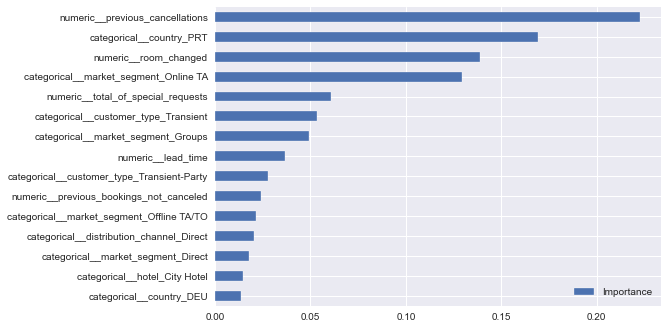

In [42]:
importances_df.sort_values('Importance', ascending=True).plot.barh()

The two clearly most important features are the number of previous cancellations and whether a customer is from Portugal. The remaining features all have a pretty low importance. Some features have importance close to 1%. For these, we might need to consider to remove them in order to improve model performance.

Next, we look at the performance of our model. For that, we define a set of standard evaluation functions we will reuse in the remainder of the notebook.

In [62]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, roc_curve
import seaborn as sns

def get_cnf_matrix(y_true, y_pred, model_name: str = None):
    """
    This function receives a true y and a predicted y array. It plots a confusion matrix as sns.heatmap.

    Parameters:
        y_true:
            numpy array or pandas Series / DF of true y values.
        y_pred:
            numpy array or pandas Series / DF of predicted y values.
        model_name(str):
            Optional parameter to specify the name of the model in the title of the plot.
    """

    cnf_matrix = confusion_matrix(y_true, y_pred)

    # Plotting the confusion matrix

    class_names=[0,1]
    fig, ax = plt.subplots(figsize=(3.5,2.8), dpi=105)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix),
                annot=True,
                cmap="YlGnBu" ,
                fmt='g',
                )#annot_kws={"size": 15, "weight": "bold"})
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(f'Confusion Matrix {model_name if model_name is not None else ""}', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


def get_metrics(y_true, y_pred):
    """
    This function receives a true y and a predicted y array. It prints Recall, Precision and Accuracy.

    Parameters:
        y_true:
            numpy array or pandas Series / DF of true y values.
        y_pred:
            numpy array or pandas Series / DF of predicted y values.
    """
    print("Recall:", round(recall_score(y_true, y_pred),4))
    print("Precision:", round(precision_score(y_true, y_pred),4))
    print("Accuracy:", round(accuracy_score(y_true, y_pred),4))
    print("F1 Score:", round(f1_score(y_true, y_pred),4))


def get_roc_curve(y_true, pred_proba):
    y_pred_proba = pred_proba[::,1]
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba)

    #create ROC curve
    plt.figure(figsize=(4.3, 4), dpi=95)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linewidth=0.5, color='grey') # plot diagonal as reference line
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')

In [19]:
y_pred = xgb_feature_selection.predict(X_test_sets[2])
y_pred_proba = xgb_feature_selection.predict_proba(X_test_sets[2])
get_metrics(df_test['is_canceled'], y_pred)
get_cnf_matrix(df_test['is_canceled'], y_pred)
get_roc_curve(df_test['is_canceled'], y_pred_proba)

NameError: name 'X_test_sets' is not defined

The model makes more false negative (customer canceled, but model did not predict the customer to do so) predictions than false postive. This also explains the relatively low recall score. Nevertheless, the ROC curve is quite balanced.

### 4.2 K-Means clustering of customers
When looking at which features are most important, it is striking that only few of the categorical features that depict the type of customer, such as the room in which they stay, the meal ordered, or the group size, are part of the top 15 features. Let's have a closer look at how these features ranked in the recursive feature elimination:

In [44]:
customer_attribs = ['guests', 'reserved_room_type', 'meal', 'stay_total_nights', 'is_family', 'hotel', 'distribution_channel', 'customer_type', 'is_repeated_guest']
feat_rank_names = feat_rank_df.index.tolist()
customer_attribs_mask = [any(customer_attrib in feat_name for customer_attrib in customer_attribs) for feat_name in feat_rank_names]
feat_rank_df[customer_attribs_mask]

,rank
categorical__distribution_channel_Direct,1
categorical__customer_type_Transient,1
categorical__hotel_City Hotel,1
categorical__customer_type_Transient-Party,1
categorical__distribution_channel_TA/TO,2
categorical__meal_Other,2
numeric__stay_total_nights,3
categorical__meal_SC,3
categorical__meal_HB,3
categorical__meal_BB,3


Only 4 of the customer characteristics made it into the top 15. The rest got eliminated pretty early. The reason for this could be that these features contain many sub-categories, so each sole subcategory does not explain cancellations sufficiently. There might still be the possibility that combined, these features actually *do* have relevance. In the following, we test this possibility by clustering customers based on their characteristics such as room type or meal and test, whether these clusters help to predict cancellations.

First, we binarize the categorical features:

In [45]:
cluster_df = df[customer_attribs]
cluster_df

,guests,reserved_room_type,meal,stay_total_nights,is_family,hotel,distribution_channel,customer_type,is_repeated_guest
0,2,C,BB,0,0,Resort Hotel,Direct,Transient,0
1,2,C,BB,0,0,Resort Hotel,Direct,Transient,0
2,1,A,BB,1,0,Resort Hotel,Direct,Transient,0
3,1,A,BB,1,0,Resort Hotel,Corporate,Transient,0
4,2,A,BB,2,0,Resort Hotel,TA/TO,Transient,0
...,...,...,...,...,...,...,...,...,...
111074,2,D,BB,6,0,City Hotel,TA/TO,Transient,0
111103,2,D,BB,7,0,City Hotel,TA/TO,Transient,0
111121,3,G,BB,6,0,City Hotel,TA/TO,Transient,0
111171,1,D,BB,11,0,City Hotel,Direct,Transient,0


In [46]:
cols_to_binarize = cluster_df.columns[cluster_df.dtypes == 'object'].tolist()
for col in cols_to_binarize:
    dummy_cols = pd.get_dummies(cluster_df[col], prefix=col)
    cluster_df = pd.concat([cluster_df, dummy_cols], axis=1)
cluster_df.drop(columns=cols_to_binarize, axis=1, inplace=True)
cluster_df

,guests,stay_total_nights,is_family,is_repeated_guest,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,...,hotel_Resort Hotel,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,2,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,1,0
1,2,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2,1,1,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
3,1,1,0,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
4,2,2,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111074,2,6,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
111103,2,7,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
111121,3,6,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
111171,1,11,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


Next, we try different cluster sizes from 2 to 10 and observe the Silhouette Score (measures separation distance between clusters) and the Calinski-Harabasz Score (measures dispersion of clusters). For both scoring metrics, a higher value indicates better performance.

100%|██████████| 9/9 [23:44<00:00, 158.24s/it]


Text(0.5, 1.0, 'Silhouette and Calinski-Harabasz Scores for Variations of k')

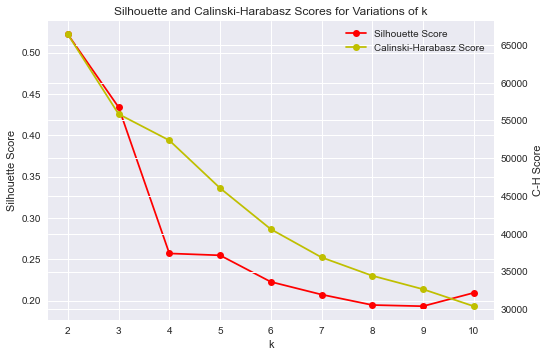

In [49]:
from sklearn.metrics import calinski_harabasz_score
from typing import List

sil_scores: List[float] = []
c_h_scores: List[float] = []
k_min = 2
k_max = 10
k_range = range(k_min, k_max+1)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(cluster_df)
    labels = kmeans.labels_
    sil_score = silhouette_score(cluster_df, labels, metric = 'euclidean')
    c_h_score = calinski_harabasz_score(cluster_df, labels)
    sil_scores.append(sil_score)
    c_h_scores.append(c_h_score)

ax1 = plt.subplot()
l1, = ax1.plot(k_range, sil_scores, marker='o', color='r')
ax2 = ax1.twinx()
l2, = ax2.plot(k_range, c_h_scores, marker='o', color='y')
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax2.set_ylabel('C-H Score')
plt.legend([l1, l2], ["Silhouette Score", "Calinski-Harabasz Score"])
plt.title('Silhouette and Calinski-Harabasz Scores for Variations of k')

For both scores, we can try to find an "elbow" to determine the best k. For the silhouette score, this elbow can be located at k=4, while for the Calinski-Harabasz Score it is not very clear, though around k=6 or 7. To account for both separation and dispersion of clusters, we selected k=5 as a good value for k to capture the elbows of both scores.

In order to understand the resulting clusters better, we can look at their sizes and the 'median customer' of each:

In [50]:
kmeans = KMeans(n_clusters=5, n_init=30, max_iter=500, random_state=seed)
kmeans.fit(cluster_df)
pd.DataFrame(data=[pd.Series(kmeans.labels_).value_counts(), pd.Series(kmeans.labels_).value_counts(normalize=True)], index=['count', 'relative']).T

,count,relative
0,41809.0,0.430187
3,41791.0,0.430002
1,11121.0,0.114428
2,2229.0,0.022935
4,238.0,0.002449


More than 80% of the customers are clustered in the top 2 clusters. The remaining clusters are very small, especially cluster 2 and 4 with only 2.3% and 0.3% respectively. Looking at the insignificant size of cluster 4, we decided to reduce k from 5 to 4.

Let's have a look at how the median customer per cluster looks like for k=4:

In [51]:
kmeans = KMeans(n_clusters=4, n_init=30, max_iter=500, random_state=seed)
kmeans.fit(cluster_df)
cluster_df['predicted_cluster'] = kmeans.labels_
cluster_df.groupby('predicted_cluster').median()

,guests,stay_total_nights,is_family,is_repeated_guest,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,...,hotel_Resort Hotel,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
predicted_cluster,,,,,,,,,,,,,,,,,,,,,
0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
clusters = cluster_df['predicted_cluster'].unique()
for cluster in clusters:
    cluster_data = cluster_df[cluster_df['predicted_cluster'] == cluster]
    percent_of_total = cluster_data.shape[0] / cluster_df.shape[0]
    print(f"Cluster {cluster} ({round(percent_of_total*100, 2)}% of total):")
    for col in [c for c in cluster_data.columns if c != 'predicted_cluster']:
        count = cluster_data[col].value_counts(normalize=True)
        top_count = count.nlargest(1)
        print(f"\t{col}: {top_count.index[0]} ({int(round(top_count.values[0]*100,0))}%)")

The clusters are not very clearly differentiated. In order to evaluate whether the resulting clusters will help to predict more accurately whether a customer cancels or not, we need to see if it improves the model performance. This will be done in 4.3 alongside variations of other features.

### 4.3 Feature Testing
#### 4.3.1 Standardized Feature Testing
First, we define a function that selects the data to be considered in the clusters. Second, we define a method that adopts the train and test set to incorporate only the features given as an argument. Third, we define a method that takes training and test sets, performs the XGBClassifier and outputs the results on the test set.

In [48]:
def make_cluster_df(cust_cluster_attribs_num, cust_cluster_attribs_bin, cust_cluster_attribs_cat):
    cluster_numeric_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    )

    cluster_binary_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median'))
        ]
    )

    cluster_categorical_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ]
    )

    clustering_preprocessing = ColumnTransformer(
        transformers=[
            ('num', cluster_numeric_transformer, cust_cluster_attribs_num),
            ('cat', cluster_categorical_transformer, cust_cluster_attribs_cat),
            ('binary', cluster_binary_transformer, cust_cluster_attribs_bin)
        ]
    )

    clustering_pipeline = Pipeline(
        steps=[
            ('preprocessor', clustering_preprocessing),
            ('kmeans', KMeans(n_clusters=4, n_init=20, max_iter=500, random_state=seed))
        ]
    )

    clustering_pipeline.fit(df)
    df_cluster_performance_train = feature_selection_df.copy()
    df_cluster_performance_test = feature_selection_test_df.copy()
    df_cluster_performance_train['customer_cluster'] = clustering_pipeline.named_steps['kmeans'].labels_
    df_cluster_performance_test['customer_cluster'] = clustering_pipeline.predict(df_test)

    return df_cluster_performance_train, df_cluster_performance_test

In [49]:
def select_features(X_clustered_train, X_clustered_test, features: list, cluster_yes: bool):
    if cluster_yes:
        features.append('customer_cluster')
    X_clustered_train = X_clustered_train[features]
    X_clustered_test = X_clustered_test[features]
    if cluster_yes:
        cluster_dummies_train = pd.get_dummies(X_clustered_train['customer_cluster'], prefix="customer_cluster")
        cluster_dummies_test = pd.get_dummies(X_clustered_test['customer_cluster'], prefix="customer_cluster")
        X_clustered_train = pd.concat([X_clustered_train, cluster_dummies_train], axis=1).drop(columns=['customer_cluster'])
        X_clustered_test = pd.concat([X_clustered_test, cluster_dummies_test], axis=1).drop(columns=['customer_cluster'])
    return X_clustered_train, X_clustered_test

In [50]:
def evalute_xgb(X_train, y_train, X_test, y_test):

    xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', objective = 'binary:logistic')
    xgb.fit(X_train, y_train)

    # Printing the metrics
    y_pred = xgb.predict(X_test)
    y_pred_proba = xgb.predict_proba(X_test)
    get_metrics(y_test, y_pred)
    get_cnf_matrix(y_test, y_pred)
    get_roc_curve(y_test, y_pred_proba)

    return xgb

In [91]:
def compare_xgb(model_1, model_2, X_test_1, X_test_2, y_true, model_1_name='Base', model_2_name='Enhanced'):
    metrics_df = pd.DataFrame(index=["F1-Score", "Accuracy", "Recall", "Precision"])
    models_iterator = zip([model_1, model_2], [X_test_1, X_test_2], [model_1_name, model_2_name])
    for model_variant in models_iterator:
        model, X_test, model_name = model_variant
        y_pred = model.predict(X_test)

        # get metrics
        f1 = f1_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        metrics = [round(metric, 4) for metric in [f1, accuracy, recall, precision]]
        model_metrics = pd.Series(name=model_name, data=metrics, index=["F1-Score", "Accuracy", "Recall", "Precision"])
        metrics_df = pd.concat([metrics_df, model_metrics], axis=1)
    metrics_df['Change'] = metrics_df.apply(lambda r: f'{"+" if (r[model_2_name] - r[model_1_name]) >= 0 else ""}{str(round(r[model_2_name] - r[model_1_name], 4))}', axis=1)

    print(metrics_df)
    get_roc_curve_multiple([model_1, model_2], [X_test_1, X_test_2], y_true, [model_1_name, model_2_name])
    for model_variant in zip([model_1, model_2], [X_test_1, X_test_2], [model_1_name, model_2_name]):
        model, X_test, model_name = model_variant
        y_pred = model.predict(X_test)
        get_cnf_matrix(y_true, y_pred, model_name)

#### 4.3.2 Do the clusters improve model performance?
In this first run we use the Top 15 features with the highest feature importance for the XGB Classifier.
In a second run we will add the previously proposed features for building the clusters.

           Base Model  With Clusters   Change
F1-Score       0.6808         0.6863  +0.0055
Accuracy       0.7607         0.7643  +0.0036
Recall         0.6293         0.6357  +0.0064
Precision      0.7416         0.7455  +0.0039


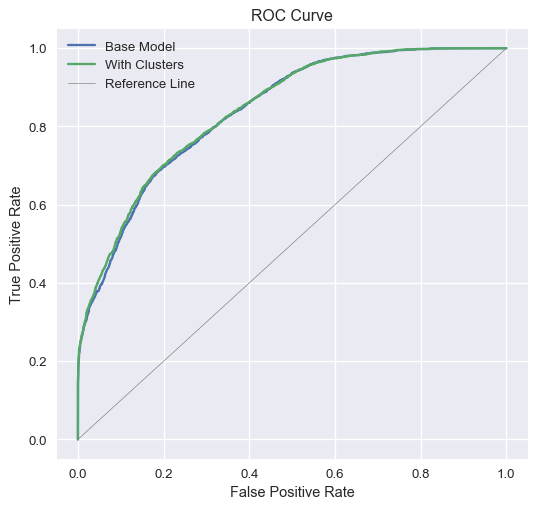

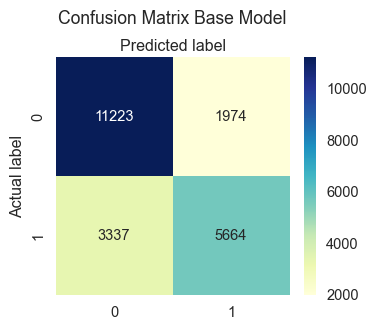

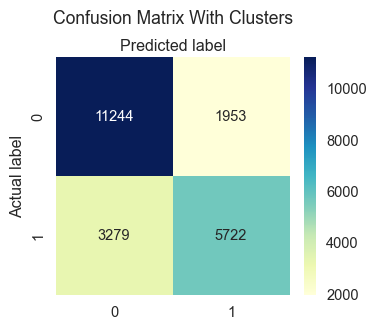

In [83]:
features_list = importances_df.index.tolist()

X_train_base, X_test_base = select_features(feature_selection_df.copy(), feature_selection_test_df.copy(), features_list, cluster_yes = False)
xgb_base = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', objective = 'binary:logistic')
xgb_base.fit(X_train_base, df['is_canceled'])
y_pred_base = xgb_base.predict(X_test_base)

cust_cluster_attribs_num = ['guests', 'stay_total_nights']
cust_cluster_attribs_bin = ['is_family', 'is_repeated_guest']
cust_cluster_attribs_cat = ['reserved_room_type', 'meal', 'hotel', 'distribution_channel', 'customer_type']

X_clustered_train, X_clustered_test = make_cluster_df(cust_cluster_attribs_num, cust_cluster_attribs_bin, cust_cluster_attribs_cat)
X_train_cluster, X_test_cluster = select_features(X_clustered_train, X_clustered_test, features_list, cluster_yes = True)

xgb_cluster = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', objective = 'binary:logistic')
xgb_cluster.fit(X_train_cluster, df['is_canceled'])
y_pred_cluster = xgb_cluster.predict(X_test_cluster)

compare_xgb(xgb_base, xgb_cluster, X_test_base, X_test_cluster, df_test['is_canceled'], 'Base Model', 'With Clusters')

Including the clusters has improved the F1 Score by 0.0055. This improvement is minor, but it is noticeable and can lead to considerably higher profits for the hotel. Furthermore, the model has not yet been optimized for the clusters (e.g., we could think about removing some clusters as features) and the score might improve further. Thus, we decide to *include the customer clusters into the further feature selection process*. It is yet to be seen though, whether the clusters will actually help model performance.

#### 4.3.3 Do more or less features improve the performance?
Using 15 as number of features in the preliminary model selection was an educated guess on a suitable amount of features. In the following we will see whether this number is actually optimal. We will check the average training F1 score of 5-fold cross-validation for number of features ranging from 5 to 40. In addition to the features used in the preliminary model selection, we also use the customer clusters as categorical features.

Text(0.5, 1.0, 'F1-Score for variations of number of features')

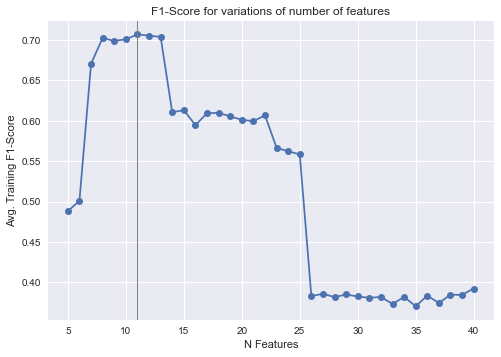

In [85]:
from sklearn.model_selection import cross_val_score

cust_cluster_attribs_num = ['guests', 'stay_total_nights']
cust_cluster_attribs_bin = ['is_family', 'is_repeated_guest']
cust_cluster_attribs_cat = ['reserved_room_type', 'meal', 'hotel', 'distribution_channel', 'customer_type']
X_clustered_train, X_clustered_test = make_cluster_df(cust_cluster_attribs_num, cust_cluster_attribs_bin, cust_cluster_attribs_cat)

n_feat_min = 5
n_feat_max = 40
n_feature_range = range(n_feat_min, n_feat_max+1)
f1_scores: List[float] = []

adv_feature_selection_df, _ = select_features(X_clustered_train, X_clustered_test, feature_selection_df.columns.tolist(), cluster_yes = True)

xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', objective = 'binary:logistic')
rfe = RFE(xgb, n_features_to_select=n_feat_min, step=1)
rfe.fit(adv_feature_selection_df, df['is_canceled'])
feat_rank_df = pd.DataFrame(data=rfe.ranking_,
                            index=adv_feature_selection_df.columns,
                            columns=['rank']).sort_values('rank', ascending=True)

for n_feat in n_feature_range:
    features_list = feat_rank_df[feat_rank_df['rank'] <= (n_feat - n_feat_min + 1)].index.tolist()

    xgb_feat = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', objective = 'binary:logistic')
    scores = cross_val_score(xgb_feat, adv_feature_selection_df[features_list], df['is_canceled'], scoring="f1", cv=5, n_jobs=-1)
    f1 = scores.mean()
    f1_scores.append(f1)
plt.plot(n_feature_range, f1_scores, marker='o')
plt.axvline(n_feature_range[np.argmax(f1_scores)], c='grey', lw=1)
plt.xlabel('N Features')
plt.ylabel('Avg. Training F1-Score')
plt.title('F1-Score for variations of number of features')

The highest training F1 Score was achieved using **14 features**. This is surprisingly close to our initial guess of 15.

Next, let's see what those features are and whether the customer clusters made the cut:

In [86]:
top_remain_features = feat_rank_df[:14].index.tolist()
top_remain_features

['categorical__market_segment_Groups',
 'numeric__previous_cancellations',
 'categorical__country_PRT',
 'numeric__room_changed',
 'categorical__market_segment_Online TA',
 'categorical__customer_type_Transient',
 'numeric__total_of_special_requests',
 'numeric__lead_time',
 'categorical__customer_type_Transient-Party',
 'categorical__distribution_channel_Direct',
 'numeric__previous_bookings_not_canceled',
 'categorical__market_segment_Offline TA/TO',
 'categorical__market_segment_Direct',
 'categorical__hotel_City Hotel']

None of the customer clusters made it into the top 14 features. Furthermore, we don't see obvious room for improvement: the included features don't belong to those features that have strong colinearity (identified in *2. EDA*) and all display unique information. Based on this, we 'trust' the model that this set of features offers little to no potential improvement.

Next, we check how a model with the identified features performs on our test set:

           15 Features  14 Features   Change
F1-Score        0.6808       0.6778   -0.003
Accuracy        0.7607       0.7584  -0.0023
Recall          0.6293       0.6266  -0.0027
Precision       0.7416       0.7380  -0.0036


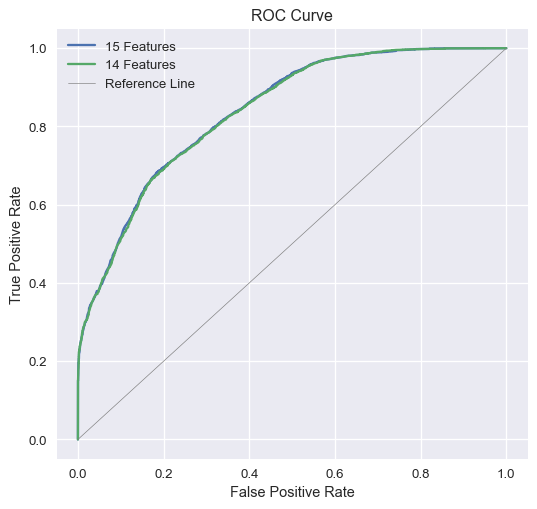

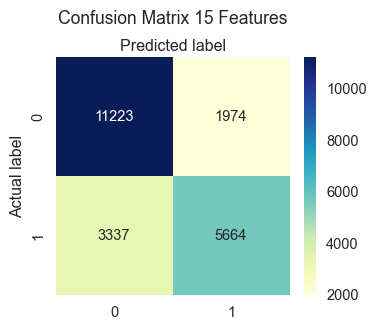

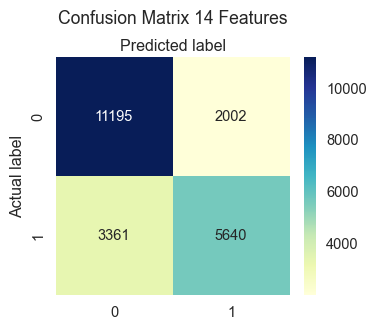

In [92]:
cust_cluster_attribs_num = ['guests', 'stay_total_nights']
cust_cluster_attribs_bin = ['is_family', 'is_repeated_guest']
cust_cluster_attribs_cat = ['reserved_room_type', 'meal', 'hotel', 'distribution_channel', 'customer_type']

X_clustered_train, X_clustered_test = make_cluster_df(cust_cluster_attribs_num, cust_cluster_attribs_bin, cust_cluster_attribs_cat)
X_train_less_feat, X_test_less_feat = select_features(X_clustered_train, X_clustered_test, top_remain_features, cluster_yes = False)
xgb_less_feat = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', objective = 'binary:logistic')
xgb_less_feat.fit(X_train_less_feat, df['is_canceled'])
y_pred_less_feat = xgb_less_feat.predict(X_test_less_feat)

compare_xgb(xgb_base, xgb_less_feat, X_test_base, X_test_less_feat, df_test['is_canceled'], '15 Features', '14 Features')

Reducing the number of features has helped us to increase the performance slightly. The performance is only marginally worse than that with clusters. Since the average F1 scores of cross-validation indicate that the clusters do not help our model and we can reduce complexity by not including clusters, we decide to **exclude customer clusters** from the model and **reduce the number of features to 14**.

### 4.4 Hyperparameter Tuning

We will use the previous methods to obtain the optimal combinations of features and clusters in X_train and X_test.

In [61]:
cust_cluster_attribs_num = ['guests', 'stay_total_nights']
cust_cluster_attribs_bin = ['is_family', 'is_repeated_guest']
cust_cluster_attribs_cat = ['reserved_room_type', 'meal', 'hotel', 'distribution_channel', 'customer_type']

X_clustered_train, X_clustered_test = make_cluster_df(cust_cluster_attribs_num, cust_cluster_attribs_bin, cust_cluster_attribs_cat)
X_train, X_test = select_features(X_clustered_train, X_clustered_test, top_remain_features, cluster_yes = False)

print(X_train.shape, X_test.shape)

(97188, 14) (22198, 14)


Now as we have our final X_train and X_test ready, we will start the hyperparameter tuning. 

As we are looking at time series data, we will be using a Time series split with an expanding window. This follows the logic of the business problem at hand. We can only use past data, to predict the cancellation rate in the future. This basic logic also holds for the process of hyperparameter tuning. 

The TimeSeriesSplit uses an expanding window, so that both the future/past logic is implemented, and a large time window is used for training. See the cell below for the splits by indices.

In [66]:
from sklearn.model_selection import TimeSeriesSplit
splitter = TimeSeriesSplit(n_splits = 5, test_size = 15000)
for train_index, test_index in search.cv.split(X_train):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [    0     1     2 ... 22185 22186 22187] TEST: [22188 22189 22190 ... 37185 37186 37187]
TRAIN: [    0     1     2 ... 37185 37186 37187] TEST: [37188 37189 37190 ... 52185 52186 52187]
TRAIN: [    0     1     2 ... 52185 52186 52187] TEST: [52188 52189 52190 ... 67185 67186 67187]
TRAIN: [    0     1     2 ... 67185 67186 67187] TEST: [67188 67189 67190 ... 82185 82186 82187]
TRAIN: [    0     1     2 ... 82185 82186 82187] TEST: [82188 82189 82190 ... 97185 97186 97187]


After that we run a randomized search CV. The hyperparameter ranges tested, were obtained through desk research as good combination of parameters for problem. The optimal parameters are used according to the highest f1-score (as discussed previously).

In [69]:
xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', objective = 'binary:logistic')

params = {
    "learning_rate" : [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],  # 0.01-0.3 (learningrate)
    "min_child_weight" : [0.5, 1, 2], 
    "max_depth" : [3, 6, 10],  # 3-10 6 is default use cv
    "min_split_loss" :[0, 10, 100, 1000],  # 0 is default 
    "subsample" : [0.5, 0.75, 1],  # 0.5-1  1 is default
    "reg_lambda" : [1, 2, 5],  # regularization term
    "scale_pos_weight" : [1, 2, 5, 10],  # Use a value greater then one in case of imbalance
}

search = RandomizedSearchCV(xgb,
                            params,
                            n_jobs =- 1,
                            n_iter = 100,
                            random_state= seed,
                            scoring = 'f1',
                            verbose = 2,
                            cv = splitter
                            )
search.fit(X_train, df['is_canceled'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/patrickgundlach/miniforge3/envs/sktimetry/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/patrickgundlach/miniforge3/envs/sktimetry/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/patrickgundlach/miniforge3/envs/sktimetry/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/patrickgundlach/miniforge3/envs/sktimetry/lib

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=15000),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           use_label_encoder=False,
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=100, n_jobs=-1,
                   param_dist

[CV] END learning_rate=0.2, max_depth=3, min_child_weight=0.5, min_split_loss=10, subsample=0.5; total time=   4.6s
[CV 1/4; 2/2] START learning_rate=0.3, max_depth=10, min_child_weight=1, min_split_loss=1000, reg_lambda=1, scale_pos_weight=5, subsample=0.75
[CV 1/4; 2/2] END learning_rate=0.3, max_depth=10, min_child_weight=1, min_split_loss=1000, reg_lambda=1, scale_pos_weight=5, subsample=0.75;, score=0.295 total time=  13.1s
[CV] END learning_rate=0.3, max_depth=6, min_child_weight=2, min_split_loss=10, reg_lambda=5, scale_pos_weight=10, subsample=0.75; total time=  11.7s
[CV] END learning_rate=0.01, max_depth=6, min_child_weight=2, min_split_loss=1000, reg_lambda=5, scale_pos_weight=5, subsample=1; total time=  11.2s
[CV] END learning_rate=0.01, max_depth=6, min_child_weight=2, min_split_loss=1000, reg_lambda=5, scale_pos_weight=5, subsample=1; total time=  15.9s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=0.5, min_split_loss=0, reg_lambda=1, scale_pos_weight=5, subs

In [92]:
pd.DataFrame(search.cv_results_).sort_values(by = 'rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_reg_lambda,param_min_split_loss,param_min_child_weight,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
37,27.214020,1.820777,0.026079,0.003079,1,1,1,10,1,10,0.01,"{'subsample': 1, 'scale_pos_weight': 1, 'reg_l...",0.463227,0.817558,0.847684,0.319894,0.0,0.489673,0.317800,1
58,11.178828,0.205730,0.014795,0.002248,0.5,1,5,10,2,6,0.3,"{'subsample': 0.5, 'scale_pos_weight': 1, 'reg...",0.428939,0.799849,0.851152,0.347785,0.0,0.485545,0.313175,2
95,25.969648,2.017456,0.019015,0.003656,0.75,1,2,100,0.5,10,0.05,"{'subsample': 0.75, 'scale_pos_weight': 1, 're...",0.470376,0.774916,0.854298,0.327795,0.0,0.485477,0.310027,3
74,25.229524,1.658185,0.019114,0.003614,1,1,5,100,1,10,0.05,"{'subsample': 1, 'scale_pos_weight': 1, 'reg_l...",0.460247,0.785687,0.855132,0.325844,0.0,0.485382,0.312595,4
45,12.413839,2.864897,0.017693,0.001058,1,1,2,10,1,6,0.05,"{'subsample': 1, 'scale_pos_weight': 1, 'reg_l...",0.447910,0.788519,0.857951,0.325664,0.0,0.484009,0.314070,5


Lets use the best estimator to run our standardized test metrics.

Recall: 0.6276
Precision: 0.7389
Accuracy: 0.7591
F1 Score: 0.6787


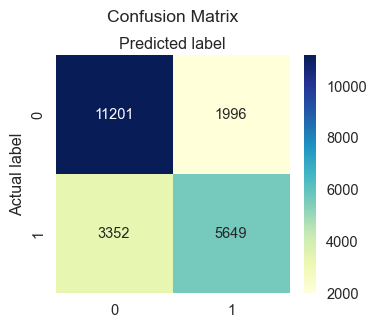

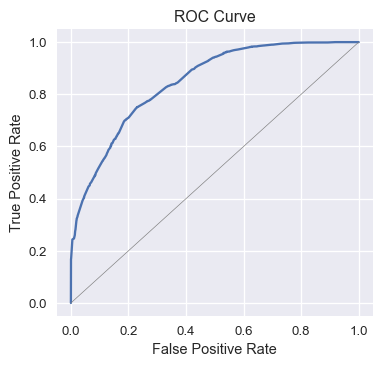

In [91]:
best_est_hparam = search.best_estimator_

y_pred_hparam = best_est_hparam.predict(X_test)
y_pred_proba_hparam = best_est_hparam.predict_proba(X_test)
get_metrics(df_test['is_canceled'], y_pred_hparam)
get_cnf_matrix(df_test['is_canceled'], y_pred_hparam)
get_roc_curve(df_test['is_canceled'], y_pred_proba_hparam)

### 4.6 Tuning Summary
Let's have a look at how our model has improved through the tuning:

In [ ]:
est_generations = [xgb_base, xgb_cluster, xgb_less_feat, xgb_less_feat]
est_predictions = [y_pred_base, y_pred_cluster, y_pred_less_feat, y_pred_less_feat]
est_descr = ["Base", "Base + Clustering", "14 Features", "14 Features + Hyperparam Tuning"]
tuning_comparison = pd.DataFrame(index=["F1-Score", "Accuracy", "Recall", "Precision"])
for i, model in enumerate(est_generations):
    f1 = f1_score(df_test['is_canceled'], est_predictions[i])
    accuracy = accuracy_score(df_test['is_canceled'], est_predictions[i])
    recall = recall_score(df_test['is_canceled'], est_predictions[i])
    precision = precision_score(df_test['is_canceled'], est_predictions[i])
    metrics = [round(metric, 4) for metric in [f1, accuracy, recall, precision]]
    model_metrics = pd.Series(name=est_descr[i], data=metrics, index=["F1-Score", "Accuracy", "Recall", "Precision"])
    tuning_comparison = tuning_comparison.join(model_metrics)
tuning_comparison

**TBD**

## 5. Final Pipeline
Now that we have determined the best model & its hyperparameters as well as the best set of features to feed into it, it'S time to construct the final pipeline with which we can put the model into production.

In [ ]:
#Define categories of attributes
num_attribs = ["lead_time", "adr", "stay_total_nights"]
num_attribs_discr = ["arrival_date_day_of_month", "arrival_date_month", "arrival_date_week_number", "room_changed"]
num_attribs_bin = ["total_of_special_requests", "previous_cancellations"]
cat_attribs_bin = [
    # (column, true value)
    ("country", "PRT"),
    ("market_segment", "Online TA"),
    ("market_segment", "Groups"),
    ("customer_type", "Transient")
]

# Create a class to select specified columns from DataFrame
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# Define function for one-vs-all binary transformation of categorical variables
def binary_tansformer_cat(arr, true_vals):
    # order of true_vals needs to be equivalent to corresponding column names in cat_attribs_bin
    for i, true_val in enumerate(true_vals):
        arr[:, i] = np.where(arr[:, i] == true_val, 1, 0)
    return arr

num_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(num_attribs)),
        ('scaler', StandardScaler())
    ])

num_discrete_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(num_attribs_discr))
    ]
)

num_binary_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(num_attribs_bin)),
        ('binarizer', Binarizer())
    ])

cat_binary_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector([e[0] for e in cat_attribs_bin])),
        ('binarizer_cat', FunctionTransformer(binary_tansformer_cat, kw_args={'true_vals': [e[1] for e in cat_attribs_bin]}))
    ])

preprocessor = FeatureUnion(
    transformer_list = [
        ('num_pipeline', num_pipeline),
        ("num_discrete_pipeline", num_discrete_pipeline),
        ("num_binary_pipeline", num_binary_pipeline),
        ("cat_binary_pipeline", cat_binary_pipeline),
#        ("cat_pipeline", cat_pipeline)
    ])
preprocessor


## <a id='businesscase'>6. Business Case Calculation</a>

### 6.1 simple day based model

In [ ]:
df_test['is_canceled_predicted'] = best_est.predict(X_test)

- If booking is canceled and we predict it correctly: + ADR from that booking
- The False Positives and Negatives are summed up per day

In [ ]:
df_profit = df_test[['is_canceled', 'is_canceled_predicted', 'arrival_date','adr']]
df_profit['correctly_classified'] = np.where((df_profit['is_canceled'] == df_profit['is_canceled_predicted']),
                                             1,
                                             0)
df_profit['additional_adr'] = np.where((df_profit['is_canceled'] == 1) & (df_profit['correctly_classified'] == 1), 
                                       df_profit['adr'],
                                       0) * 0.8
display(df_profit)
average_adr = df_profit.adr.mean()

df_profit_agg = df_profit.groupby('arrival_date').sum()
df_profit_agg['overbooked_rooms'] = df_profit_agg['is_canceled_predicted'] - df_profit_agg['is_canceled']
df_profit_agg['overbooked_rooms'] = np.where(df_profit_agg['overbooked_rooms'] < 0, 
                                                0, 
                                                df_profit_agg['overbooked_rooms'])
df_profit_agg['neg_adr_overbooking'] = df_profit_agg['overbooked_rooms'] * average_adr * 1.2
df_profit_agg

In [ ]:
round(df_profit_agg.additional_adr.sum() - df_profit_agg.neg_adr_overbooking.sum(),2)

## 7. Appendix

### 7.1 ADR per Person
We've seen that both the number of persons and the adr are features that influence whether a booking is cancelled or not. At the same time, adr is highly correlated with group size. Let's see if calculating the adr per person helps to explain cancellations as it removes the information captured in group size already.

First, we construct different versions of the adr per person: One per guest (including babies and children) and one per adult. This way we ensure to test whether the pricing structure of the hotel also reflects whether children or babies are part of the guests.

In [ ]:
df_adr = df.copy()
df_adr['adults'].replace({0: df_adr['adults'].median()}, inplace=True)
df_adr['guests'].replace({0: df_adr['guests'].median()}, inplace=True)
df_adr['adr_per_guest'] = df_adr['adr'] / df_adr['guests']
df_adr['adr_per_adult'] = df_adr['adr'] / df_adr['adults']

Let's see the correlation with is_cancelled for all versions and the original adr...

In [ ]:
df_adr[['adr', 'adr_per_guest', 'adr_per_adult', 'is_canceled']].corr()['is_canceled']

Unfortunately, the adr per person does not help us more in explaining cancellations than the group adr does.

### 7.2 K-Means clustering of customers *[BACKUP]*
In 3.2, it is striking that only few of the categorical features that depict the type of customer, such as the room in which they stay, the meal ordered, or the group size are part of the top 15 features. Let's have a closer look at how these features ranked in the recursive feature elimination:

In [ ]:
customer_attribs = ['guests', 'reserved_room_type', 'meal', 'stay_total_nights', 'is_family', 'hotel', 'distribution_channel', 'customer_type', 'is_repeated_guest']
feat_rank_names = feat_rank_df.index.tolist()
customer_attribs_mask = [any(customer_attrib in feat_name for customer_attrib in customer_attribs) for feat_name in feat_rank_names]
feat_rank_df[customer_attribs_mask]

Only 2 of the customer characteristics made it into the top 15. The rest got kicked out pretty early. The reason for this could be that these features contain that many sub-categories, that each sole subcategory does not explain cancellations sufficiently. There might still be the possibility that combined, these features *do* actually have relevance. In the following, we test this possibility by clustering customers based on their characteristics such as room type or meal and test, whether these clusters help to predict cancellations.

First, we binarize the categorical features:

In [ ]:
cluster_df = df[customer_attribs]
cluster_df

In [ ]:
cols_to_binarize = cluster_df.columns[cluster_df.dtypes == 'object'].tolist()
for col in cols_to_binarize:
    dummy_cols = pd.get_dummies(cluster_df[col], prefix=col)
    cluster_df = pd.concat([cluster_df, dummy_cols], axis=1)
cluster_df.drop(columns=cols_to_binarize, axis=1, inplace=True)
cluster_df

Next, we try different cluster sizes from 2 to 10 and observe the silhouette score obtained for each k:

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

scores = []
k_min = 2
k_max = 10
k_range = range(k_min, k_max+1)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(cluster_df)
    labels = kmeans.labels_
    score = silhouette_score(cluster_df, labels, metric = 'euclidean')
    scores.append(score)
plt.plot(k_range, scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Variations of k')

The resulting silhouette score is highest for k=2. This though would not help us much, since the resulting clusters would very likely only be split between city and resort hotel. Thus, we want to choose a higher k, that can reflect differences within each hotel type as well. In the following, we'll work with k=4.

In order to understand the resulting clusters better, we can look at their sizes and the 'median customer' of each:

In [ ]:
kmeans = KMeans(n_clusters=4, n_init=30, max_iter=500, random_state=seed)
kmeans.fit(cluster_df)
pd.DataFrame(data=[pd.Series(kmeans.labels_).value_counts(), pd.Series(kmeans.labels_).value_counts(normalize=True)], index=['count', 'relative']).T

More than 80% of the customers are clustered in the top 2 clusters. The remaining clusters are very small, especially cluster 2 with only 1.4%.

Let's have a look at how the median customer per cluster looks like:

In [ ]:
cluster_df['predicted_cluster'] = kmeans.labels_
cluster_df.groupby('predicted_cluster').median()

In [ ]:
clusters = cluster_df['predicted_cluster'].unique()
for cluster in clusters:
    cluster_data = cluster_df[cluster_df['predicted_cluster'] == cluster]
    percent_of_total = cluster_data.shape[0] / cluster_df.shape[0]
    print(f"Cluster {cluster} ({round(percent_of_total*100, 2)}% of total):")
    for col in [c for c in cluster_data.columns if c != 'predicted_cluster']:
        count = cluster_data[col].value_counts(normalize=True)
        top_count = count.nlargest(1)
        print(f"\t{col}: {top_count.index[0]} ({int(round(top_count.values[0]*100,0))}%)")

Next, we need to understand whether the clustering will improve our model performance. For simplicity, we only take the current best working model (Random Forest) and compare the obtained scores.

First, we construct the pipeline for k-means clustering:

In [ ]:
cust_cluster_attribs_num = ['guests', 'stay_total_nights']
cust_cluster_attribs_bin = ['is_family', 'is_repeated_guest']
cust_cluster_attribs_cat = ['reserved_room_type', 'meal', 'hotel', 'distribution_channel', 'customer_type']

cluster_numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

cluster_binary_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ]
)

cluster_categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)

clustering_preprocessing = ColumnTransformer(
    transformers=[
        ('num', cluster_numeric_transformer, cust_cluster_attribs_num),
        ('cat', cluster_categorical_transformer, cust_cluster_attribs_cat),
        ('binary', cluster_binary_transformer, cust_cluster_attribs_bin)
    ]
)

clustering_pipeline = Pipeline(
    steps=[
        ('preprocessor', clustering_preprocessing),
        ('kmeans', KMeans(n_clusters=4, n_init=20, max_iter=500, random_state=seed))
    ]
)

clustering_pipeline.fit(df)

Then we enrich the train set with clusters resulting from the previously constructed and fitted pipeline, and the test set with the predicted clusters from that pipeline:

In [ ]:
df_cluster_performance_train = df.copy()
df_cluster_performance_test = df_test.copy()
df_cluster_performance_train['customer_cluster'] = clustering_pipeline.named_steps['kmeans'].labels_
df_cluster_performance_test['customer_cluster'] = clustering_pipeline.predict(df_cluster_performance_test)
#df_cluster_performance_train['customer_cluster'] = kmeans.labels_
#df_cluster_performance_test['customer_cluster'] = kmeans.predict(truncator.transform(clustering_preprocessing.fit_transform(df_cluster_performance_test)))

In order to compare the models, we need to include the customer clusters in our preprocessing pipeline. We do this by appending a pipeline that one-hot-encodes the clusters:

In [ ]:
transformers = preprocessor.transformer_list.copy()

cluster_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(['customer_cluster'])),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)
transformers.append(('cluster_pipeline', cluster_pipeline))
preprocessor_w_clustering = FeatureUnion(transformers)

Ready to go. Now we can get the train and test set and compare the performance of a model with and without customer clusters.

In [ ]:
X_train_cluster = preprocessor_w_clustering.fit_transform(df_cluster_performance_train)
y_train_cluster = df_cluster_performance_train['is_canceled']

X_test_cluster = preprocessor_w_clustering.fit_transform(df_cluster_performance_test)
y_test_cluster = df_cluster_performance_test['is_canceled']

In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.base import clone

rf_original = clone(best_rf).fit(X_train, y_train)
rf_cluster = clone(best_rf).fit(X_train_cluster, y_train_cluster)

models = [rf_original, rf_cluster]
model_names = ['Original', 'With Clusters']
model_test_sets = [(X_test, y_test), (X_test_cluster, y_test_cluster)]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
comparison_df = pd.DataFrame(index=metrics)
for i, model in enumerate(models):
    model_pred = model.predict(model_test_sets[i][0])
    model_y_test = model_test_sets[i][1]
    accuracy = round(accuracy_score(model_y_test, model_pred), 4)
    recall = round(recall_score(model_y_test, model_pred), 4)
    precision = round(precision_score(model_y_test, model_pred), 4)
    f1 = round(f1_score(model_y_test, model_pred), 4)

    model_statistics = pd.DataFrame(index=metrics, data=[accuracy, precision, recall, f1], columns=[model_names[i]])
    comparison_df = comparison_df.join(model_statistics)
comparison_df

### 7.2 K-Means clustering of customers *[BACKUP]*
In 3.2, it is striking that only few of the categorical features that depict the type of customer, such as the room in which they stay, the meal ordered, or the group size are part of the top 15 features. Let's have a closer look at how these features ranked in the recursive feature elimination:

In [ ]:
customer_attribs = ['guests', 'reserved_room_type', 'meal', 'stay_total_nights', 'is_family', 'hotel', 'distribution_channel', 'customer_type', 'is_repeated_guest']
feat_rank_names = feat_rank_df.index.tolist()
customer_attribs_mask = [any(customer_attrib in feat_name for customer_attrib in customer_attribs) for feat_name in feat_rank_names]
feat_rank_df[customer_attribs_mask]

Only 2 of the customer characteristics made it into the top 15. The rest got kicked out pretty early. The reason for this could be that these features contain that many sub-categories, that each sole subcategory does not explain cancellations sufficiently. There might still be the possibility that combined, these features *do* actually have relevance. In the following, we test this possibility by clustering customers based on their characteristics such as room type or meal and test, whether these clusters help to predict cancellations.

First, we binarize the categorical features:

In [ ]:
cluster_df = df[customer_attribs]
cluster_df

In [ ]:
cols_to_binarize = cluster_df.columns[cluster_df.dtypes == 'object'].tolist()
for col in cols_to_binarize:
    dummy_cols = pd.get_dummies(cluster_df[col], prefix=col)
    cluster_df = pd.concat([cluster_df, dummy_cols], axis=1)
cluster_df.drop(columns=cols_to_binarize, axis=1, inplace=True)
cluster_df

Next, we try different cluster sizes from 2 to 10 and observe the silhouette score obtained for each k:

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

scores = []
k_min = 2
k_max = 10
k_range = range(k_min, k_max+1)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(cluster_df)
    labels = kmeans.labels_
    score = silhouette_score(cluster_df, labels, metric = 'euclidean')
    scores.append(score)
plt.plot(k_range, scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Variations of k')

The resulting silhouette score is highest for k=2. This though would not help us much, since the resulting clusters would very likely only be split between city and resort hotel. Thus, we want to choose a higher k, that can reflect differences within each hotel type as well. In the following, we'll work with k=4.

In order to understand the resulting clusters better, we can look at their sizes and the 'median customer' of each:

In [ ]:
kmeans = KMeans(n_clusters=4, n_init=30, max_iter=500, random_state=seed)
kmeans.fit(cluster_df)
pd.DataFrame(data=[pd.Series(kmeans.labels_).value_counts(), pd.Series(kmeans.labels_).value_counts(normalize=True)], index=['count', 'relative']).T

More than 80% of the customers are clustered in the top 2 clusters. The remaining clusters are very small, especially cluster 2 with only 1.4%.

Let's have a look at how the median customer per cluster looks like:

In [ ]:
cluster_df['predicted_cluster'] = kmeans.labels_
cluster_df.groupby('predicted_cluster').median()

In [ ]:
clusters = cluster_df['predicted_cluster'].unique()
for cluster in clusters:
    cluster_data = cluster_df[cluster_df['predicted_cluster'] == cluster]
    percent_of_total = cluster_data.shape[0] / cluster_df.shape[0]
    print(f"Cluster {cluster} ({round(percent_of_total*100, 2)}% of total):")
    for col in [c for c in cluster_data.columns if c != 'predicted_cluster']:
        count = cluster_data[col].value_counts(normalize=True)
        top_count = count.nlargest(1)
        print(f"\t{col}: {top_count.index[0]} ({int(round(top_count.values[0]*100,0))}%)")

Next, we need to understand whether the clustering will improve our model performance. For simplicity, we only take the current best working model (Random Forest) and compare the obtained scores.

First, we construct the pipeline for k-means clustering:

In [ ]:
cust_cluster_attribs_num = ['guests', 'stay_total_nights']
cust_cluster_attribs_bin = ['is_family', 'is_repeated_guest']
cust_cluster_attribs_cat = ['reserved_room_type', 'meal', 'hotel', 'distribution_channel', 'customer_type']

cluster_numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

cluster_binary_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ]
)

cluster_categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)

clustering_preprocessing = ColumnTransformer(
    transformers=[
        ('num', cluster_numeric_transformer, cust_cluster_attribs_num),
        ('cat', cluster_categorical_transformer, cust_cluster_attribs_cat),
        ('binary', cluster_binary_transformer, cust_cluster_attribs_bin)
    ]
)

clustering_pipeline = Pipeline(
    steps=[
        ('preprocessor', clustering_preprocessing),
        ('kmeans', KMeans(n_clusters=4, n_init=20, max_iter=500, random_state=seed))
    ]
)

clustering_pipeline.fit(df)

Then we enrich the train set with clusters resulting from the previously constructed and fitted pipeline, and the test set with the predicted clusters from that pipeline:

In [ ]:
df_cluster_performance_train = df.copy()
df_cluster_performance_test = df_test.copy()
df_cluster_performance_train['customer_cluster'] = clustering_pipeline.named_steps['kmeans'].labels_
df_cluster_performance_test['customer_cluster'] = clustering_pipeline.predict(df_cluster_performance_test)
#df_cluster_performance_train['customer_cluster'] = kmeans.labels_
#df_cluster_performance_test['customer_cluster'] = kmeans.predict(truncator.transform(clustering_preprocessing.fit_transform(df_cluster_performance_test)))

In order to compare the models, we need to include the customer clusters in our preprocessing pipeline. We do this by appending a pipeline that one-hot-encodes the clusters:

In [ ]:
transformers = preprocessor.transformer_list.copy()

cluster_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(['customer_cluster'])),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)
transformers.append(('cluster_pipeline', cluster_pipeline))
preprocessor_w_clustering = FeatureUnion(transformers)

Ready to go. Now we can get the train and test set and compare the performance of a model with and without customer clusters.

In [ ]:
X_train_cluster = preprocessor_w_clustering.fit_transform(df_cluster_performance_train)
y_train_cluster = df_cluster_performance_train['is_canceled']

X_test_cluster = preprocessor_w_clustering.fit_transform(df_cluster_performance_test)
y_test_cluster = df_cluster_performance_test['is_canceled']

In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.base import clone

rf_original = clone(best_rf).fit(X_train, y_train)
rf_cluster = clone(best_rf).fit(X_train_cluster, y_train_cluster)

models = [rf_original, rf_cluster]
model_names = ['Original', 'With Clusters']
model_test_sets = [(X_test, y_test), (X_test_cluster, y_test_cluster)]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
comparison_df = pd.DataFrame(index=metrics)
for i, model in enumerate(models):
    model_pred = model.predict(model_test_sets[i][0])
    model_y_test = model_test_sets[i][1]
    accuracy = round(accuracy_score(model_y_test, model_pred), 4)
    recall = round(recall_score(model_y_test, model_pred), 4)
    precision = round(precision_score(model_y_test, model_pred), 4)
    f1 = round(f1_score(model_y_test, model_pred), 4)

    model_statistics = pd.DataFrame(index=metrics, data=[accuracy, precision, recall, f1], columns=[model_names[i]])
    comparison_df = comparison_df.join(model_statistics)
comparison_df

The model performance increased very, very slightly.

Let's have a look at how important the clusters are for the predictions:

In [ ]:
print(f"Importances: {rf_cluster.feature_importances_[-4:]}")
print(f"Total: {round(sum(rf_cluster.feature_importances_[-4:])*100, 1)}%")

Each of the resulting clusters added low importance (<=1%) to the model. Altogether, the clusters account for only ~2.7% of the model's feature importances.

sns.violinplot(data=df, x='hotel', y='lead_time', hue='is_canceled', split=True)
plt.show()**Conclusion for Customer Clusters:**
<br>Clustering the customers into clusters only helps to improve the model performance very slightly. At the same time, it adds additional computation time and complexity. Considering this, we will refrain from using customer clusters as features in the final model.